## Configuración inicial

A continuación se importan las librerías necesarias para el funcionamiento del notebook.

In [1]:
#plots and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#metrics and transformations
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics

#Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow import random 
from tensorflow.keras import callbacks

sns.set()

---

## Cargar y preparar los datos.

In [2]:
df = pd.read_csv("../../Datasets/Datos_durante_pandemia/data_durante_vol_in_ic.csv")

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha', ascending=True)
df = df.rename(columns = {'Futuros': 'Vol. Futuros'})
df

Fecha  Vol. Futuros        VIX  EMV-ID     EPU    PI    MHI   FNI  \
0   2020-01-01      1.289946  12.548403    1.89  186.06  0.00   0.00  0.00   
1   2020-01-02      0.735046  12.470000    2.84  139.13  0.00   0.00  0.00   
2   2020-01-03      0.591834  14.020000    1.33  108.10  0.00   0.00  0.00   
3   2020-01-04      1.367154  14.646666    0.00  212.82  0.00   0.00  0.00   
4   2020-01-05      1.505321  14.311970    0.86  173.76  0.00   0.00  0.00   
..         ...           ...        ...     ...     ...   ...    ...   ...   
913 2022-07-02      0.778572  25.922916   11.11  130.95  4.66  25.71  0.19   
914 2022-07-03      0.819483  26.641413   23.06  135.95  0.42   7.76  0.00   
915 2022-07-04      0.843804  27.530000   15.98  309.83  0.54  31.37  0.27   
916 2022-07-05      0.850985  27.540000   18.90  116.59  0.48  38.21  0.12   
917 2022-07-06      0.840437  26.730000    2.27   91.52  0.52  27.93  0.00   

       SI  
0    0.00  
1    0.00  
2    0.00  
3    0.00  
4    0.00  
..    ...  
913 -3.56  
914 -3.67  
915 -5.85  
916 -4.97  
917 -7.87  

[918 rows x 9 columns]

---

## Desarrollo del modelo

In [4]:
#objects to scale the data 
sc=StandardScaler()
sc2=StandardScaler()

In [5]:
df_stats=df

In [6]:
#
len_data=df_stats.shape[0]

#get target
df_label=df_stats["Vol. Futuros"].values.reshape(len_data,1)
#get attributes
df_data=df_stats.drop(columns=["Fecha"])

#apply scale
df_label_normalize=sc.fit_transform(df_label)
df_data_normalize=sc2.fit_transform(df_data)


### Partición de los datos

In [7]:
#last index of the train data
eight_percent=int(len_data*0.7)

#split the data normalize
df_train=df_data_normalize[:eight_percent]
df_test=df_data_normalize[eight_percent:]

#split labels normalize
df_train_y_normalize=df_label_normalize[:eight_percent]
df_test_y_normalize=df_label_normalize[eight_percent:]

#split the original labels
df_train_y=df_label[:eight_percent]
df_test_y=df_label[eight_percent:]

In [8]:
def plot_metrics(history):
        # plot MAE and loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='mae')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['loss'], label='loss')
    plt.ylabel("value")
    plt.xlabel("epoch")
    plt.title("error a través de los epochs")
    plt.legend()
    plt.show()

In [9]:
def plot_predict_test(df_test_y,testPredict,lag):
        ### Resultado predicción datos de entrenamiento
    fig, ax = plt.subplots(figsize=[15,8])
    sns.lineplot(df_test_y[lag:].flatten(),label="real")
    sns.lineplot(testPredict.flatten(),label="predicción")
    plt.title("Comparación valor real y predicción")
    plt.ylabel("value")

In [10]:
#function to measure the performance
def timeseries_evaluation_metrics_func(y_true, y_pred,flag):
    def mean_absolute_percentage_error(y_true, y_pred): 
        epsilon=0.1e-5
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if flag : print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    else:
        print('Evaluation metric results:')
        print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
        print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
        print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
        print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
        
    return {"MSE":metrics.mean_squared_error(y_true, y_pred),
           "MAE":metrics.mean_absolute_error(y_true, y_pred),
           "RMSE":np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
           "MAPE":mean_absolute_percentage_error(y_true, y_pred)}

In [11]:
def Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons,attributes,epochss,batch_sizze,lag):
    #reshape train data
    lag=lag
    len_df_train=df_train.shape[0]
    X_train=[]
    Y_train=[]
    for i in range(lag,len_df_train):
        X_train.append(df_train[i-lag:i])
        Y_train.append(df_train_y_normalize[i])

    X_train,Y_train=np.array(X_train),np.array(Y_train)
    print(X_train.shape,Y_train.shape)
    
    #reshape test data
    len_df_test=df_test.shape[0]
    X_test=[]
    Y_test=[]
    for i in range(lag,len_df_test):
        X_test.append(df_test[i-lag:i])
        Y_test.append(df_test_y_normalize[i])

    X_test,Y_test=np.array(X_test),np.array(Y_test)
    print(X_test.shape,Y_test.shape)
    
    
    #set the seed
    random.set_seed(7)

    #optional----
    #callback to early stopping and prevent overfitting
    #callback =callbacks.EarlyStopping(monitor='mae', patience=3)

    #make the model
    model=Sequential()
    model.add(LSTM(units=neurons,return_sequences=False,input_shape=(lag,attributes)))
    model.add(Dense(1))
    model.compile(optimizer='adamax',loss='mean_squared_error',metrics=['mae'])
    
    #fit the model with the train data
    history=model.fit(X_train,Y_train,validation_split=0.2,epochs=epochss,batch_size=batch_sizze)
    
    #plot metrics
    plot_metrics(history)
    
    # make predictions
    trainPredict = model.predict(X_train)

    # invert transformation
    trainPredict = sc.inverse_transform(trainPredict)
    trainY = df_train_y
    
    # make predictions
    model.reset_states()
    testPredict = model.predict(X_test)


    # invert transformation
    testPredict = sc.inverse_transform(testPredict)
    testY = df_test_y
    
    plot_predict_test(df_train_y,trainPredict,lag)
    plot_predict_test(df_test_y,testPredict,lag)
    return [{"Fecha":df_stats.Fecha[lag:eight_percent],"typeLSTM":["train"]*len(trainPredict.flatten()),"LSTM" :trainPredict.flatten()}
        ,{"Fecha":df_stats.Fecha[eight_percent+lag:],"typeLSTM":["test"]*len(testPredict.flatten()),"LSTM":testPredict.flatten()}]
    
    return {"train":timeseries_evaluation_metrics_func(trainY.flatten()[lag:]+1, trainPredict.flatten()+1,False),
           "test":timeseries_evaluation_metrics_func(testY.flatten()[lag:]+1, testPredict.flatten()+1,False)}

## Resultados

(637, 5, 8) (637, 1)
(271, 5, 8) (271, 1)
Epoch 1/100
32/32 [==============================] - 3s 23ms/step - loss: 1.0237 - mae: 0.7858 - val_loss: 1.4797 - val_mae: 0.7629
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.9522 - mae: 0.7404 - val_loss: 1.4771 - val_mae: 0.7675
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.9208 - mae: 0.7229 - val_loss: 1.4754 - val_mae: 0.7696
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.9058 - mae: 0.7106 - val_loss: 1.4735 - val_mae: 0.7700
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.8965 - mae: 0.7049 - val_loss: 1.4703 - val_mae: 0.7714
Epoch 6/100
32/32 [==============================] - 0s 5ms/step - loss: 0.8907 - mae: 0.7015 - val_loss: 1.4670 - val_mae: 0.7708
Epoch 7/100
32/32 [==============================] - 0s 5ms/step - loss: 0.8869 - mae: 0.6979 - val_loss: 1.4652 - val_mae: 0.7710
Epoch 8/100
32/32 [=====================

Epoch 63/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7706 - mae: 0.6564 - val_loss: 1.3977 - val_mae: 0.7592
Epoch 64/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7693 - mae: 0.6557 - val_loss: 1.3973 - val_mae: 0.7599
Epoch 65/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7677 - mae: 0.6544 - val_loss: 1.3976 - val_mae: 0.7596
Epoch 66/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7657 - mae: 0.6540 - val_loss: 1.3968 - val_mae: 0.7584
Epoch 67/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7649 - mae: 0.6555 - val_loss: 1.3991 - val_mae: 0.7609
Epoch 68/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7624 - mae: 0.6540 - val_loss: 1.3977 - val_mae: 0.7608
Epoch 69/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7603 - mae: 0.6530 - val_loss: 1.3985 - val_mae: 0.7614
Epoch 70/100
32/32 [==============================] - 0s 6ms/step - loss: 0.

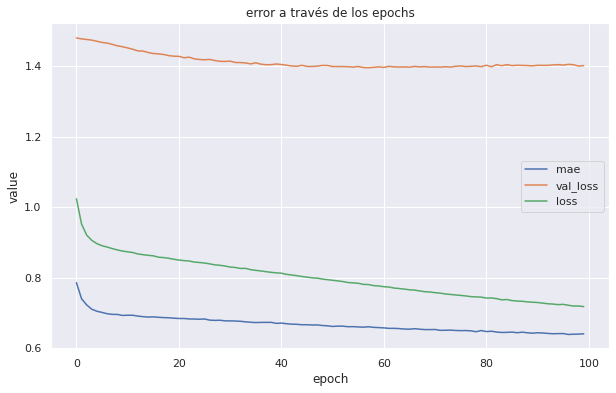

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.3283866305650511
MAE is : 0.8312105804353648
RMSE is : 1.1525565628484578
MAPE is : 40.1279002414143
Evaluation metric results:
MSE is : 1.2939075391793575
MAE is : 0.8782060864630014
RMSE is : 1.1375005666721039
MAPE is : 41.657474221075404
(637, 5, 8) (637, 1)
(271, 5, 8) (271, 1)
Epoch 1/100
32/32 [==============================] - 3s 23ms/step - loss: 0.9553 - mae: 0.7238 - val_loss: 1.5411 - val_mae: 0.7937
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9192 - mae: 0.7122 - val_loss: 1.5170 - val_mae: 0.7823
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.9042 - mae: 0.7109 - val_loss: 1.5048 - val_mae: 0.7746
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.8915 - mae: 0.7053 - val_loss: 1.4945 - val_mae: 0.7705
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.8822 - mae: 0.7019 - val_lo

Epoch 60/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7156 - mae: 0.6385 - val_loss: 1.3687 - val_mae: 0.7438
Epoch 61/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7134 - mae: 0.6387 - val_loss: 1.3654 - val_mae: 0.7430
Epoch 62/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7124 - mae: 0.6352 - val_loss: 1.3701 - val_mae: 0.7436
Epoch 63/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7083 - mae: 0.6370 - val_loss: 1.3679 - val_mae: 0.7442
Epoch 64/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7071 - mae: 0.6351 - val_loss: 1.3677 - val_mae: 0.7454
Epoch 65/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7048 - mae: 0.6340 - val_loss: 1.3681 - val_mae: 0.7458
Epoch 66/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7027 - mae: 0.6333 - val_loss: 1.3667 - val_mae: 0.7438
Epoch 67/100
32/32 [==============================] - 0s 6ms/step - loss: 0.

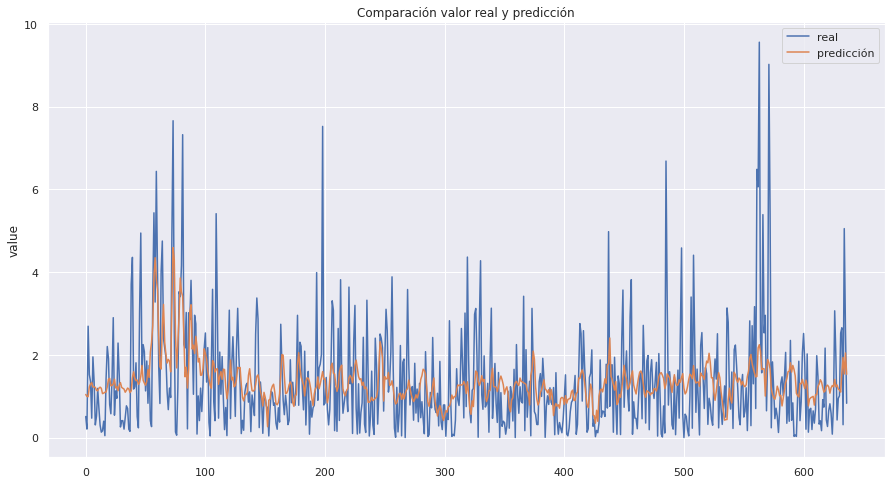

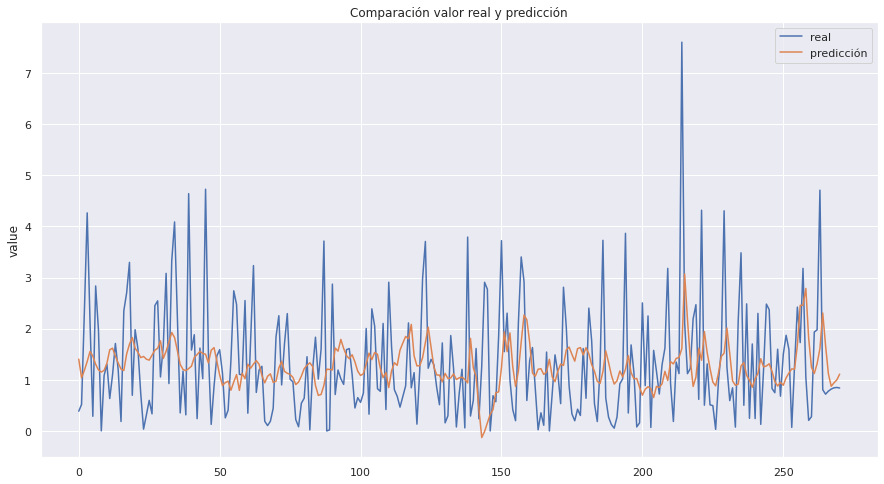

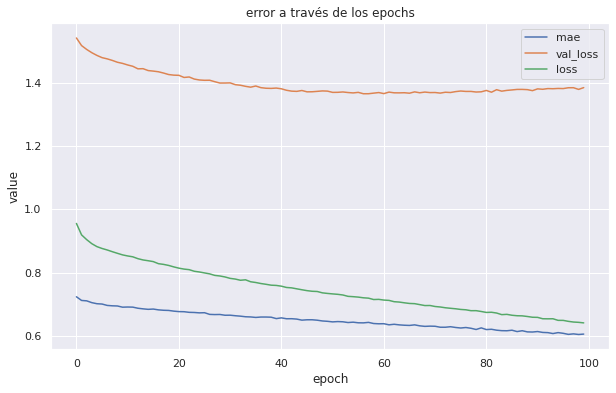

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.2247583507791944
MAE is : 0.7959822150625983
RMSE is : 1.106688009684389
MAPE is : 38.728012767607865
Evaluation metric results:
MSE is : 1.3040919936843027
MAE is : 0.8788980652001689
RMSE is : 1.1419684731569006
MAPE is : 41.59654225727667
(637, 5, 8) (637, 1)
(271, 5, 8) (271, 1)
Epoch 1/100
32/32 [==============================] - 3s 25ms/step - loss: 0.9347 - mae: 0.7288 - val_loss: 1.4809 - val_mae: 0.7778
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.9025 - mae: 0.7074 - val_loss: 1.4635 - val_mae: 0.7755
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.8886 - mae: 0.7059 - val_loss: 1.4574 - val_mae: 0.7718
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.8770 - mae: 0.6973 - val_loss: 1.4474 - val_mae: 0.7703
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.8683 - mae: 0.6941 - val_lo

Epoch 60/100
32/32 [==============================] - 0s 7ms/step - loss: 0.6871 - mae: 0.6286 - val_loss: 1.3378 - val_mae: 0.7511
Epoch 61/100
32/32 [==============================] - 0s 7ms/step - loss: 0.6823 - mae: 0.6275 - val_loss: 1.3306 - val_mae: 0.7515
Epoch 62/100
32/32 [==============================] - 0s 7ms/step - loss: 0.6801 - mae: 0.6221 - val_loss: 1.3394 - val_mae: 0.7503
Epoch 63/100
32/32 [==============================] - 0s 7ms/step - loss: 0.6768 - mae: 0.6267 - val_loss: 1.3378 - val_mae: 0.7559
Epoch 64/100
32/32 [==============================] - 0s 7ms/step - loss: 0.6732 - mae: 0.6213 - val_loss: 1.3360 - val_mae: 0.7538
Epoch 65/100
32/32 [==============================] - 0s 7ms/step - loss: 0.6725 - mae: 0.6215 - val_loss: 1.3409 - val_mae: 0.7564
Epoch 66/100
32/32 [==============================] - 0s 7ms/step - loss: 0.6687 - mae: 0.6200 - val_loss: 1.3345 - val_mae: 0.7503
Epoch 67/100
32/32 [==============================] - 0s 7ms/step - loss: 0.

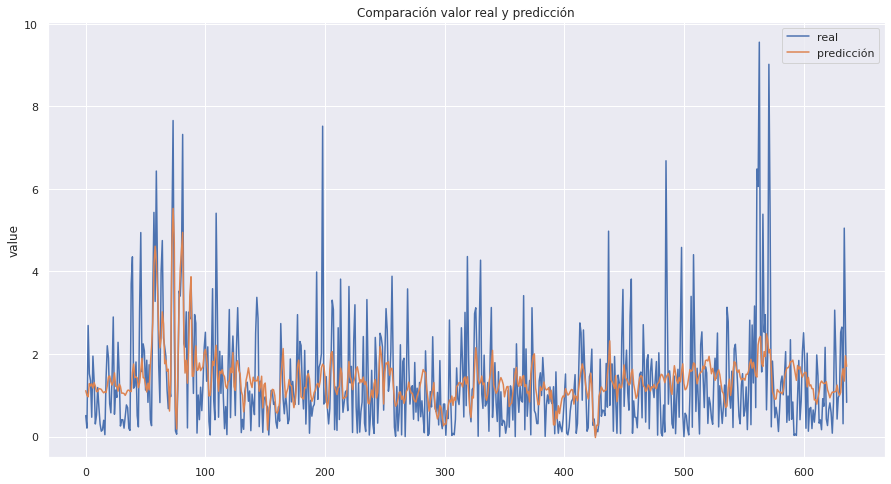

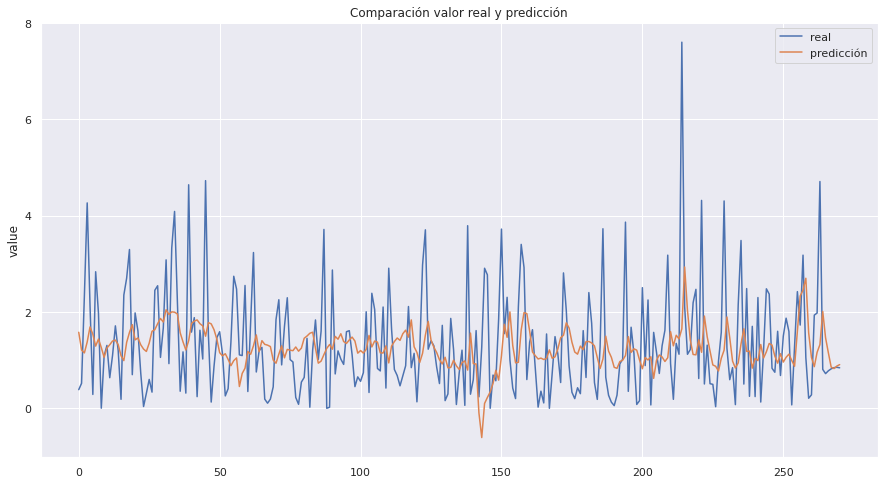

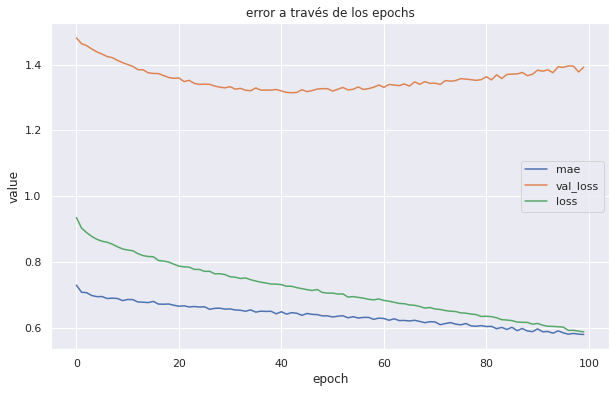

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.1558358861664384
MAE is : 0.7686504464798761
RMSE is : 1.0750980821145755
MAPE is : 37.35131201490468
Evaluation metric results:
MSE is : 1.3254142045800863
MAE is : 0.8884438644281115
RMSE is : 1.151266348235753
MAPE is : 43.31210239928362
(637, 5, 8) (637, 1)
(271, 5, 8) (271, 1)
Epoch 1/100
32/32 [==============================] - 3s 28ms/step - loss: 0.9217 - mae: 0.7168 - val_loss: 1.4489 - val_mae: 0.7603
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8875 - mae: 0.7002 - val_loss: 1.4253 - val_mae: 0.7601
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8693 - mae: 0.7016 - val_loss: 1.4259 - val_mae: 0.7632
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8569 - mae: 0.6913 - val_loss: 1.4143 - val_mae: 0.7588
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8434 - mae: 0.6889 - val_los

Epoch 60/100
32/32 [==============================] - 0s 9ms/step - loss: 0.6401 - mae: 0.6077 - val_loss: 1.3220 - val_mae: 0.7672
Epoch 61/100
32/32 [==============================] - 0s 8ms/step - loss: 0.6289 - mae: 0.6000 - val_loss: 1.3214 - val_mae: 0.7751
Epoch 62/100
32/32 [==============================] - 0s 9ms/step - loss: 0.6278 - mae: 0.5993 - val_loss: 1.3153 - val_mae: 0.7641
Epoch 63/100
32/32 [==============================] - 0s 9ms/step - loss: 0.6257 - mae: 0.5994 - val_loss: 1.3264 - val_mae: 0.7796
Epoch 64/100
32/32 [==============================] - 0s 10ms/step - loss: 0.6157 - mae: 0.5946 - val_loss: 1.3193 - val_mae: 0.7742
Epoch 65/100
32/32 [==============================] - 0s 8ms/step - loss: 0.6186 - mae: 0.5955 - val_loss: 1.3229 - val_mae: 0.7718
Epoch 66/100
32/32 [==============================] - 0s 8ms/step - loss: 0.6199 - mae: 0.5930 - val_loss: 1.3033 - val_mae: 0.7656
Epoch 67/100
32/32 [==============================] - 0s 9ms/step - loss: 0

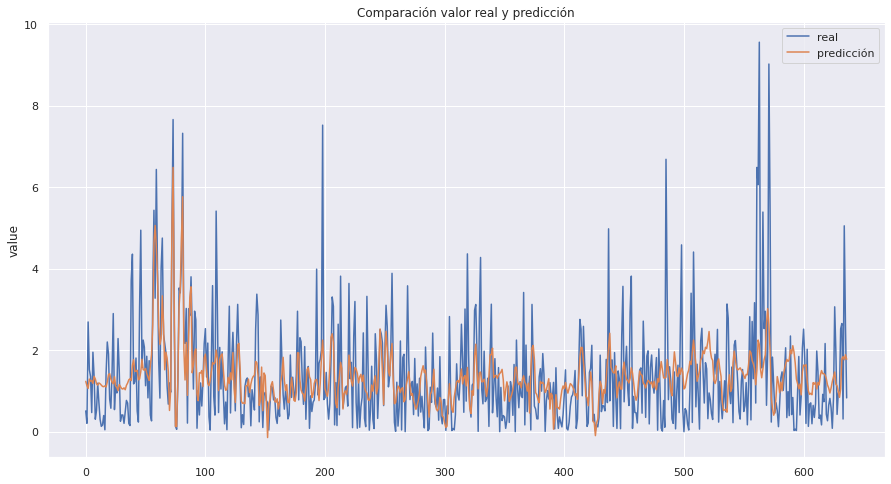

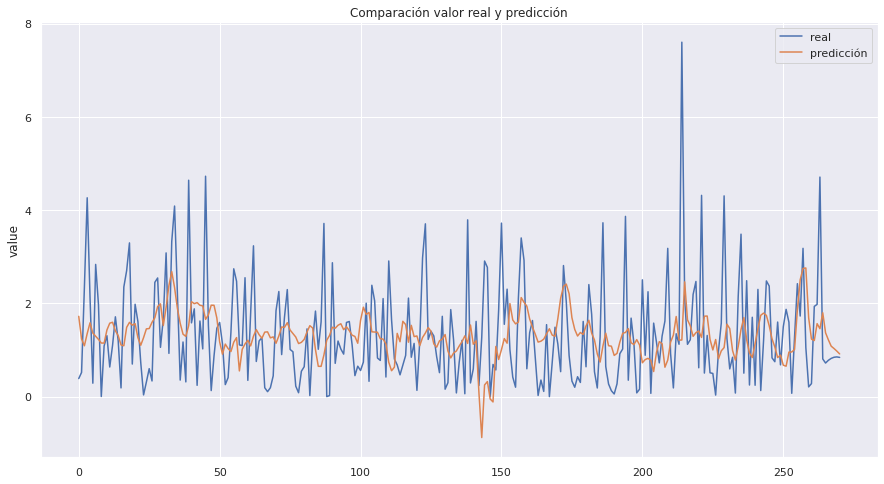

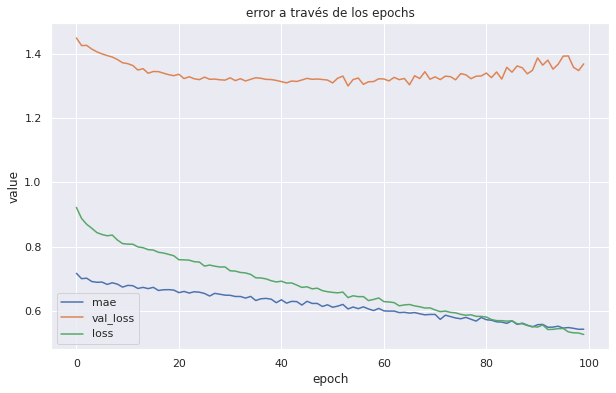

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.0716490103221736
MAE is : 0.7339586267802872
RMSE is : 1.0352048156389988
MAPE is : 36.19683243284117
Evaluation metric results:
MSE is : 1.4435490495127383
MAE is : 0.928766990729874
RMSE is : 1.201477860600327
MAPE is : 45.54512763226831
(637, 5, 8) (637, 1)
(271, 5, 8) (271, 1)
Epoch 1/100
32/32 [==============================] - 4s 32ms/step - loss: 0.9127 - mae: 0.7154 - val_loss: 1.4833 - val_mae: 0.7565
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 0.8722 - mae: 0.6987 - val_loss: 1.4286 - val_mae: 0.7455
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.8490 - mae: 0.6994 - val_loss: 1.4260 - val_mae: 0.7594
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.8453 - mae: 0.6916 - val_loss: 1.4055 - val_mae: 0.7448
Epoch 5/100
32/32 [==============================] - 0s 13ms/step - loss: 0.8252 - mae: 0.6857 - val_

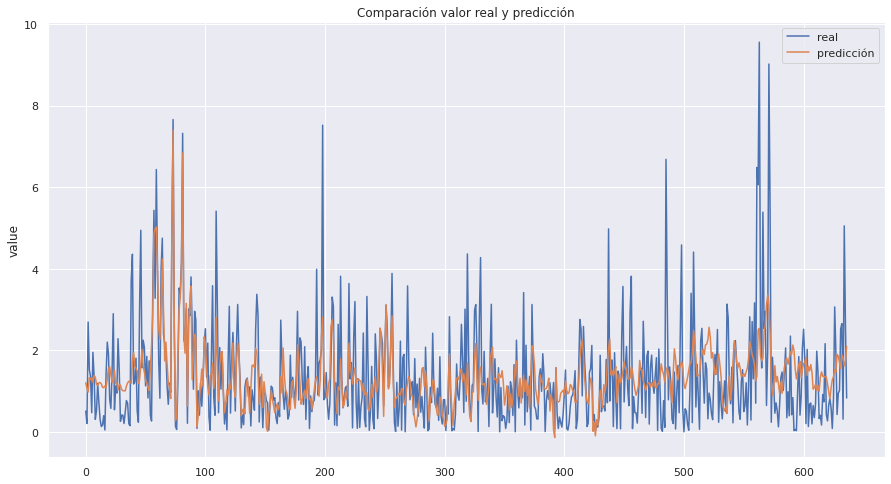

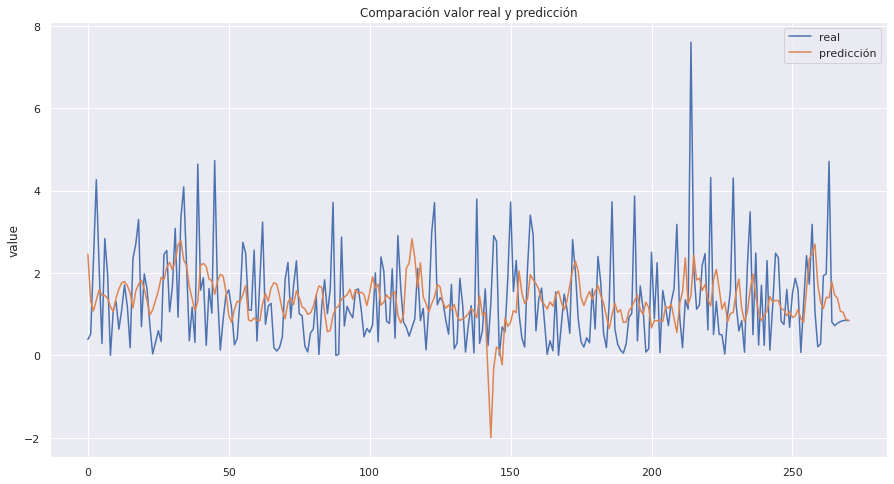

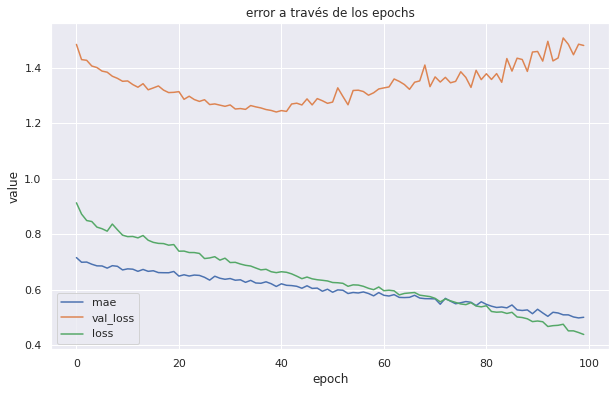

9/9 [==============================] - 0s 5ms/step
Evaluation metric results:
MSE is : 0.982933934954542
MAE is : 0.6966397628999413
RMSE is : 0.9914302471452755
MAPE is : 34.656593818225936
Evaluation metric results:
MSE is : 1.6924611877485332
MAE is : 1.0003609693111621
RMSE is : 1.3009462662802538
MAPE is : 50.421113536684395
(637, 5, 8) (637, 1)
(271, 5, 8) (271, 1)
Epoch 1/100
32/32 [==============================] - 3s 41ms/step - loss: 0.9149 - mae: 0.7172 - val_loss: 1.5025 - val_mae: 0.7611
Epoch 2/100
32/32 [==============================] - 1s 22ms/step - loss: 0.8723 - mae: 0.7014 - val_loss: 1.4321 - val_mae: 0.7446
Epoch 3/100
32/32 [==============================] - 1s 22ms/step - loss: 0.8415 - mae: 0.6971 - val_loss: 1.4232 - val_mae: 0.7561
Epoch 4/100
32/32 [==============================] - 1s 22ms/step - loss: 0.8454 - mae: 0.6927 - val_loss: 1.3934 - val_mae: 0.7421
Epoch 5/100
32/32 [==============================] - 1s 22ms/step - loss: 0.8206 - mae: 0.6846 - v

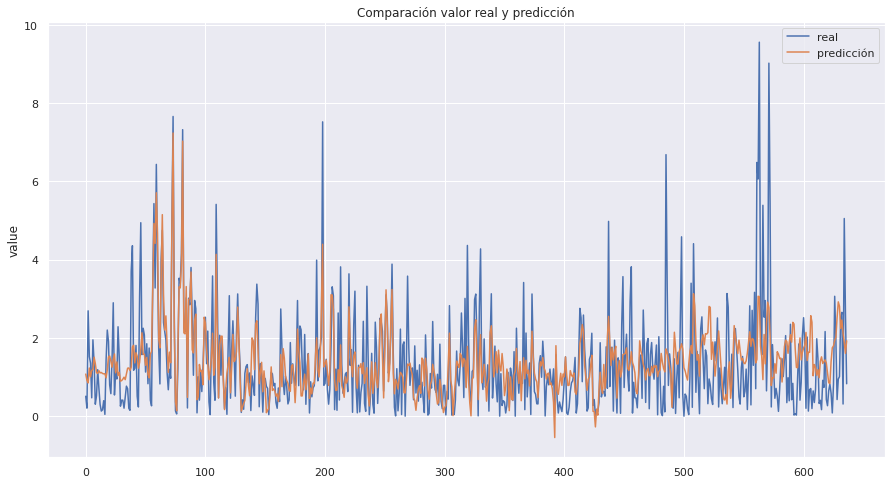

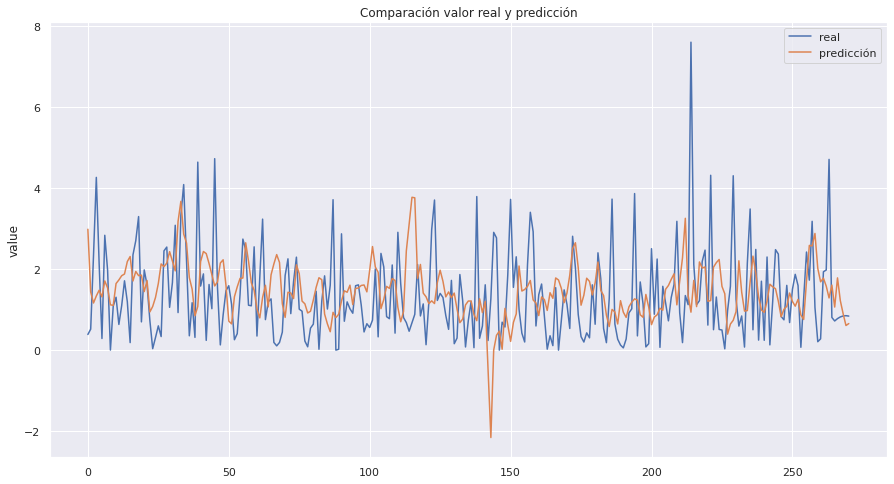

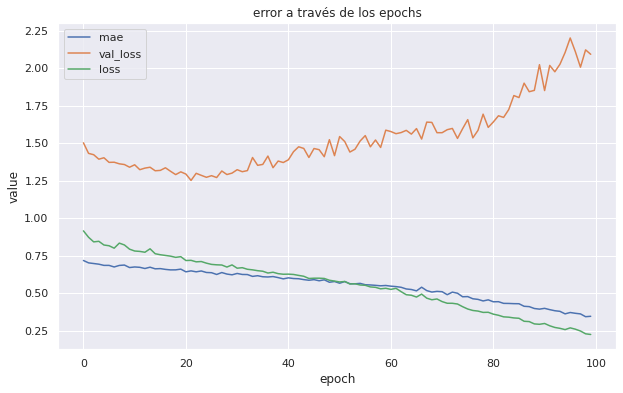

9/9 [==============================] - 0s 11ms/step
Evaluation metric results:
MSE is : 0.9165133555281525
MAE is : 0.5789625704621704
RMSE is : 0.957347040277533
MAPE is : 28.12926841260483
Evaluation metric results:
MSE is : 2.3100294298155224
MAE is : 1.1698507810019307
RMSE is : 1.5198780970247325
MAPE is : 56.33250889889475
(634, 8, 8) (634, 1)
(268, 8, 8) (268, 1)
Epoch 1/100
32/32 [==============================] - 3s 27ms/step - loss: 1.0109 - mae: 0.7588 - val_loss: 1.7386 - val_mae: 0.8463
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.9706 - mae: 0.7406 - val_loss: 1.7114 - val_mae: 0.8337
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9466 - mae: 0.7299 - val_loss: 1.6859 - val_mae: 0.8282
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9290 - mae: 0.7205 - val_loss: 1.6575 - val_mae: 0.8221
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9147 - mae: 0.7145 - val_lo

Epoch 60/100
32/32 [==============================] - 0s 7ms/step - loss: 0.7790 - mae: 0.6591 - val_loss: 1.4962 - val_mae: 0.8122
Epoch 61/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7777 - mae: 0.6573 - val_loss: 1.5025 - val_mae: 0.8148
Epoch 62/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7759 - mae: 0.6566 - val_loss: 1.5061 - val_mae: 0.8181
Epoch 63/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7745 - mae: 0.6569 - val_loss: 1.5052 - val_mae: 0.8171
Epoch 64/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7732 - mae: 0.6568 - val_loss: 1.5097 - val_mae: 0.8177
Epoch 65/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7713 - mae: 0.6549 - val_loss: 1.5087 - val_mae: 0.8199
Epoch 66/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7697 - mae: 0.6544 - val_loss: 1.5138 - val_mae: 0.8191
Epoch 67/100
32/32 [==============================] - 0s 8ms/step - loss: 0.

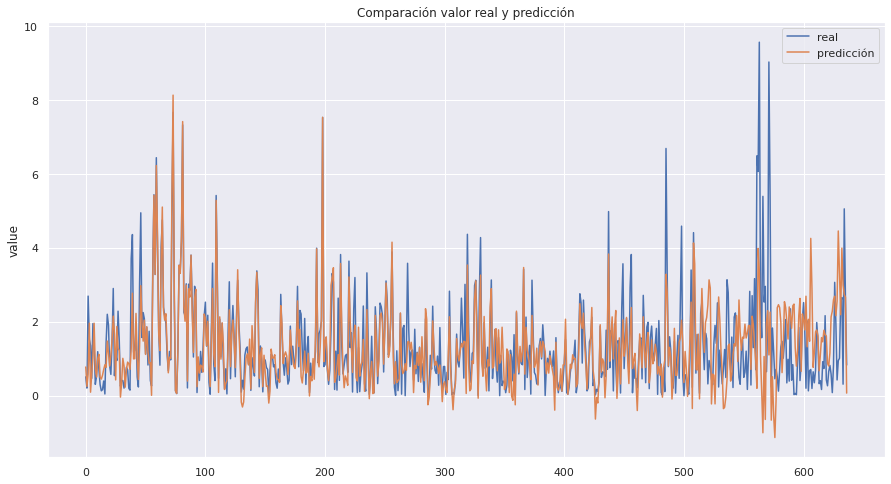

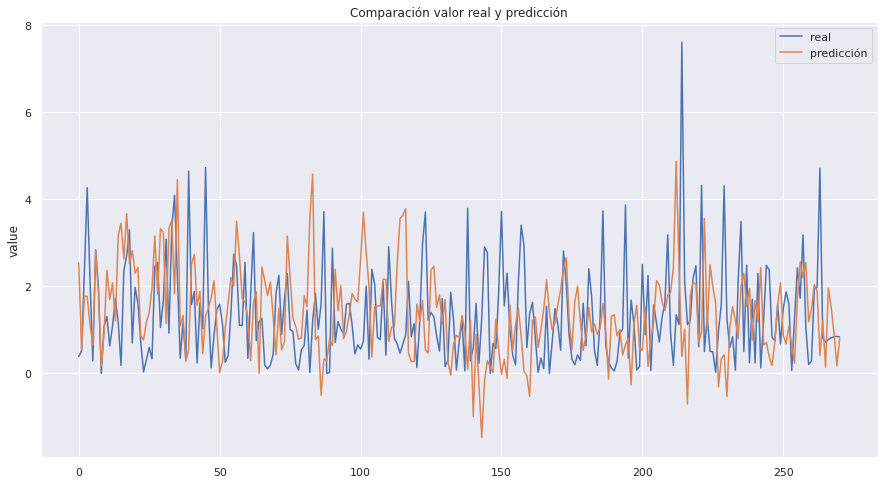

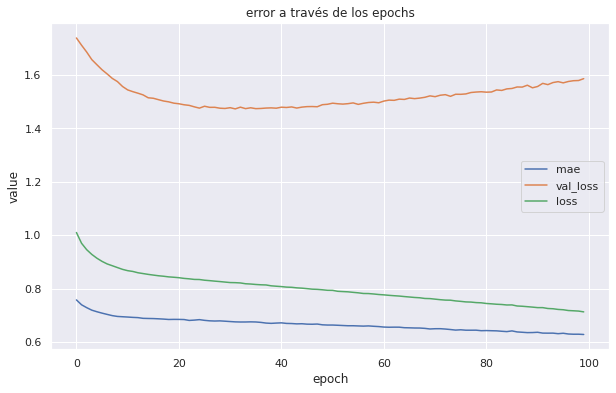

9/9 [==============================] - 0s 2ms/step
Evaluation metric results:
MSE is : 1.380332316365099
MAE is : 0.8394797487414117
RMSE is : 1.1748754471709326
MAPE is : 41.23049289061007
Evaluation metric results:
MSE is : 1.2832048431369374
MAE is : 0.8594365411100461
RMSE is : 1.132786318392369
MAPE is : 40.347551832081244
(634, 8, 8) (634, 1)
(268, 8, 8) (268, 1)
Epoch 1/100
32/32 [==============================] - 3s 29ms/step - loss: 0.9163 - mae: 0.7273 - val_loss: 1.5325 - val_mae: 0.8009
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8883 - mae: 0.7044 - val_loss: 1.5241 - val_mae: 0.7838
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8779 - mae: 0.6981 - val_loss: 1.5128 - val_mae: 0.7833
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8723 - mae: 0.6929 - val_loss: 1.4988 - val_mae: 0.7801
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8684 - mae: 0.6921 - val_los

Epoch 60/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7142 - mae: 0.6255 - val_loss: 1.5307 - val_mae: 0.8080
Epoch 61/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7116 - mae: 0.6221 - val_loss: 1.5388 - val_mae: 0.8137
Epoch 62/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7098 - mae: 0.6246 - val_loss: 1.5414 - val_mae: 0.8175
Epoch 63/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7052 - mae: 0.6239 - val_loss: 1.5425 - val_mae: 0.8151
Epoch 64/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7015 - mae: 0.6217 - val_loss: 1.5471 - val_mae: 0.8162
Epoch 65/100
32/32 [==============================] - 0s 8ms/step - loss: 0.6997 - mae: 0.6170 - val_loss: 1.5404 - val_mae: 0.8157
Epoch 66/100
32/32 [==============================] - 0s 9ms/step - loss: 0.6956 - mae: 0.6203 - val_loss: 1.5498 - val_mae: 0.8152
Epoch 67/100
32/32 [==============================] - 0s 9ms/step - loss: 0.

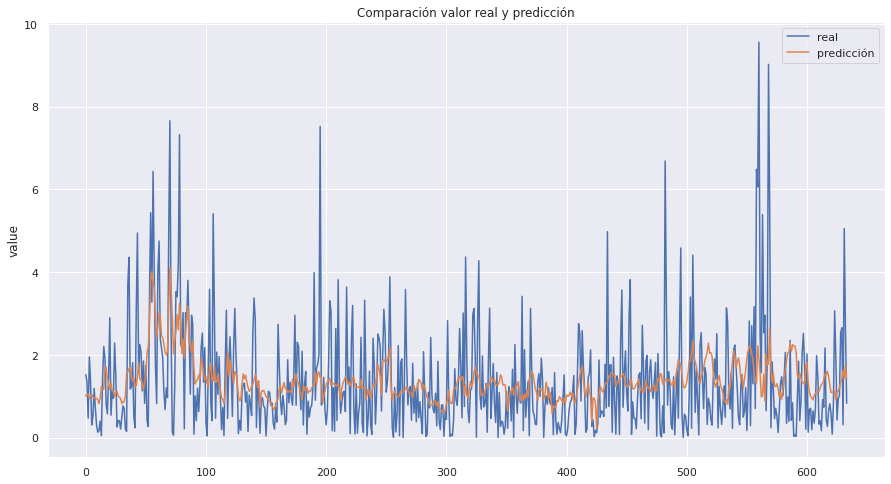

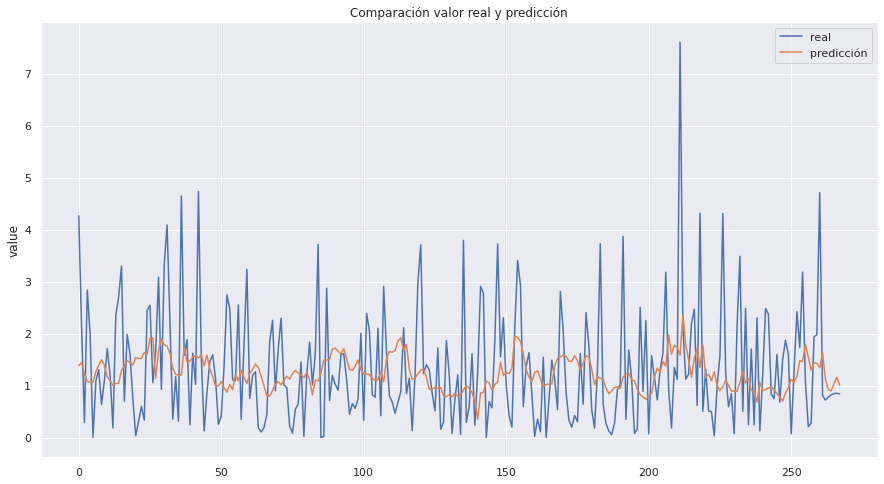

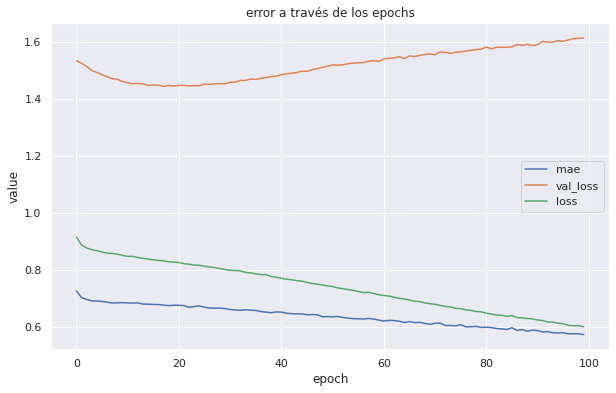

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.2410545194650213
MAE is : 0.781343385708031
RMSE is : 1.1140262651594088
MAPE is : 37.71348951255025
Evaluation metric results:
MSE is : 1.2529584522720962
MAE is : 0.8422340034233918
RMSE is : 1.1193562669106276
MAPE is : 39.00517345989173
(634, 8, 8) (634, 1)
(268, 8, 8) (268, 1)
Epoch 1/100
32/32 [==============================] - 3s 28ms/step - loss: 0.9780 - mae: 0.7264 - val_loss: 1.4261 - val_mae: 0.7894
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.9120 - mae: 0.7066 - val_loss: 1.4123 - val_mae: 0.7679
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8929 - mae: 0.6964 - val_loss: 1.4104 - val_mae: 0.7699
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8841 - mae: 0.6918 - val_loss: 1.4027 - val_mae: 0.7673
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8783 - mae: 0.6932 - val_los

Epoch 60/100
32/32 [==============================] - 0s 9ms/step - loss: 0.6393 - mae: 0.5955 - val_loss: 1.4834 - val_mae: 0.8250
Epoch 61/100
32/32 [==============================] - 0s 9ms/step - loss: 0.6329 - mae: 0.5880 - val_loss: 1.4902 - val_mae: 0.8307
Epoch 62/100
32/32 [==============================] - 0s 9ms/step - loss: 0.6282 - mae: 0.5899 - val_loss: 1.5041 - val_mae: 0.8399
Epoch 63/100
32/32 [==============================] - 0s 9ms/step - loss: 0.6234 - mae: 0.5921 - val_loss: 1.5024 - val_mae: 0.8385
Epoch 64/100
32/32 [==============================] - 0s 9ms/step - loss: 0.6254 - mae: 0.5880 - val_loss: 1.5087 - val_mae: 0.8385
Epoch 65/100
32/32 [==============================] - 0s 9ms/step - loss: 0.6175 - mae: 0.5838 - val_loss: 1.5005 - val_mae: 0.8337
Epoch 66/100
32/32 [==============================] - 0s 8ms/step - loss: 0.6151 - mae: 0.5849 - val_loss: 1.5095 - val_mae: 0.8349
Epoch 67/100
32/32 [==============================] - 0s 8ms/step - loss: 0.

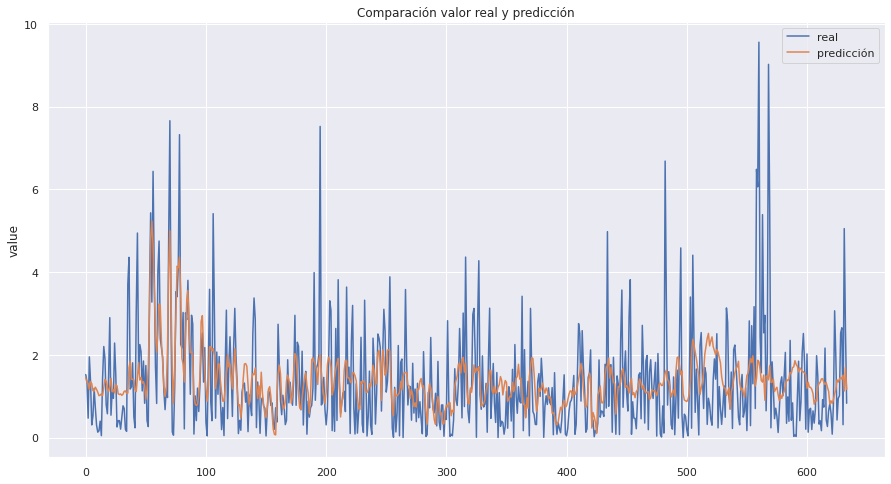

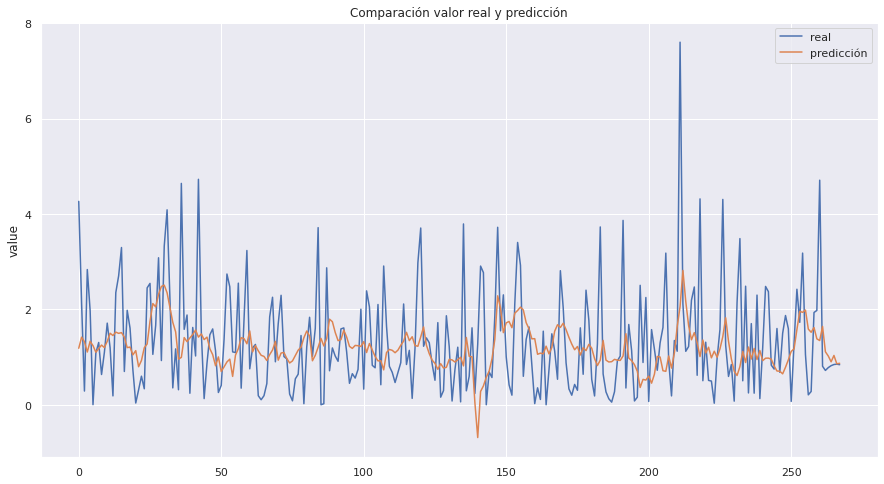

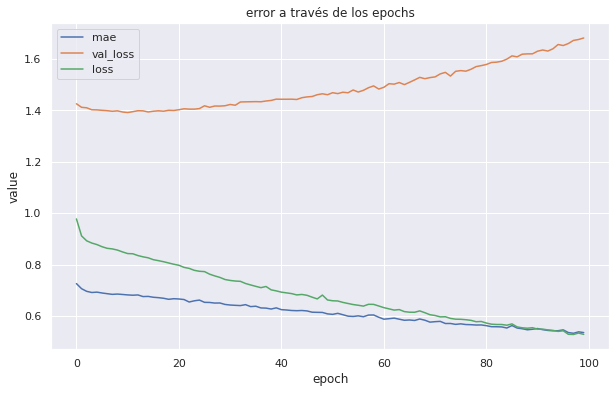

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.1618184666985703
MAE is : 0.7479361367822931
RMSE is : 1.077876832805386
MAPE is : 36.736428021084016
Evaluation metric results:
MSE is : 1.360738104831676
MAE is : 0.874402706507025
RMSE is : 1.166506795878908
MAPE is : 42.13172344030466
(634, 8, 8) (634, 1)
(268, 8, 8) (268, 1)
Epoch 1/100
32/32 [==============================] - 4s 31ms/step - loss: 0.9603 - mae: 0.7305 - val_loss: 1.4766 - val_mae: 0.7785
Epoch 2/100
32/32 [==============================] - 0s 11ms/step - loss: 0.8928 - mae: 0.7012 - val_loss: 1.4584 - val_mae: 0.7613
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.8775 - mae: 0.6918 - val_loss: 1.4408 - val_mae: 0.7687
Epoch 4/100
32/32 [==============================] - 0s 11ms/step - loss: 0.8697 - mae: 0.6896 - val_loss: 1.4203 - val_mae: 0.7584
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.8667 - mae: 0.6944 - val_l

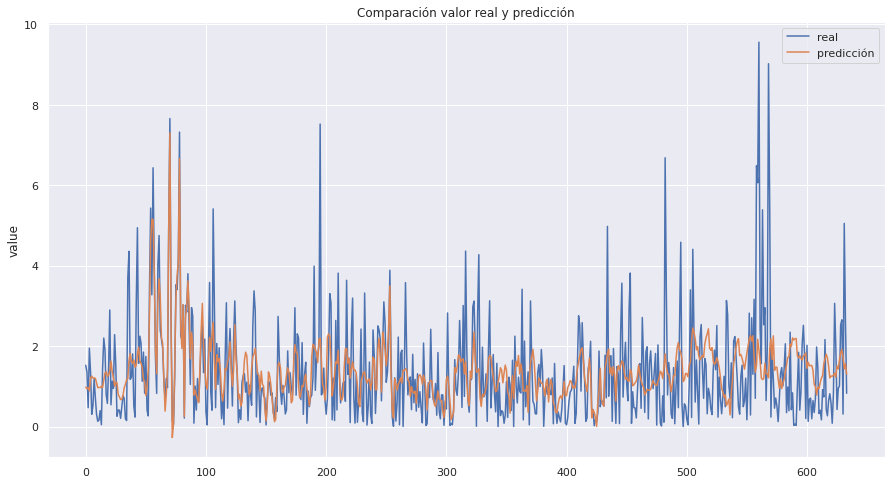

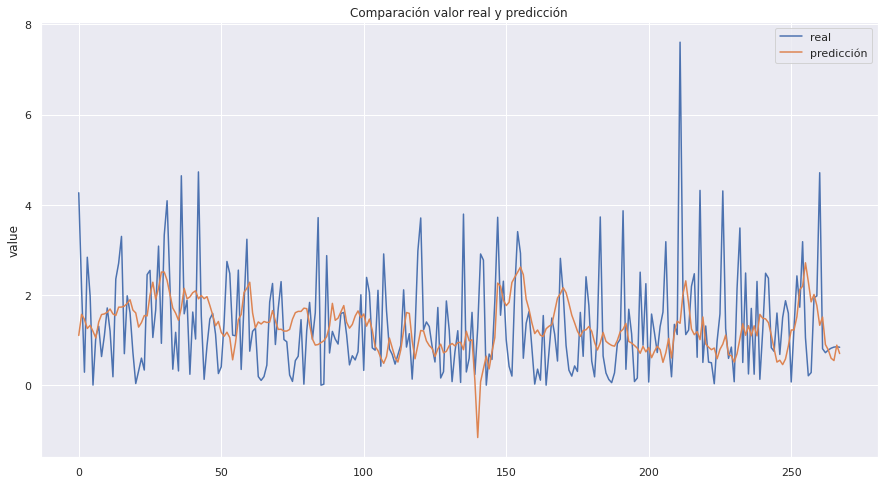

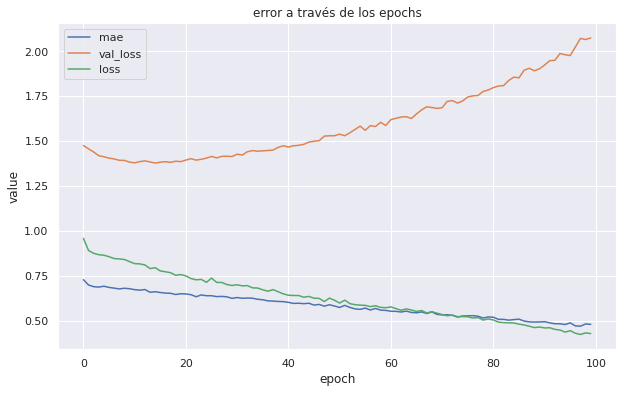

9/9 [==============================] - 0s 5ms/step
Evaluation metric results:
MSE is : 1.1457857650338292
MAE is : 0.7145624299326542
RMSE is : 1.0704138288689236
MAPE is : 35.888517974808295
Evaluation metric results:
MSE is : 1.7167190755165593
MAE is : 1.005910127515549
RMSE is : 1.3102362670589451
MAPE is : 48.49069420427737
(634, 8, 8) (634, 1)
(268, 8, 8) (268, 1)
Epoch 1/100
32/32 [==============================] - 3s 35ms/step - loss: 0.9753 - mae: 0.7314 - val_loss: 1.4406 - val_mae: 0.7775
Epoch 2/100
32/32 [==============================] - 1s 16ms/step - loss: 0.8827 - mae: 0.7010 - val_loss: 1.4425 - val_mae: 0.7575
Epoch 3/100
32/32 [==============================] - 1s 17ms/step - loss: 0.8650 - mae: 0.6906 - val_loss: 1.4283 - val_mae: 0.7643
Epoch 4/100
32/32 [==============================] - 0s 15ms/step - loss: 0.8557 - mae: 0.6888 - val_loss: 1.4066 - val_mae: 0.7522
Epoch 5/100
32/32 [==============================] - 0s 16ms/step - loss: 0.8547 - mae: 0.6928 - va

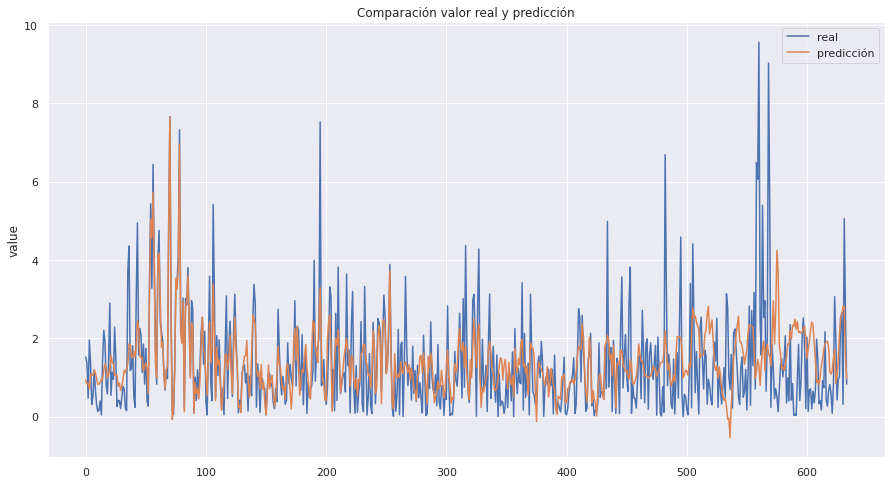

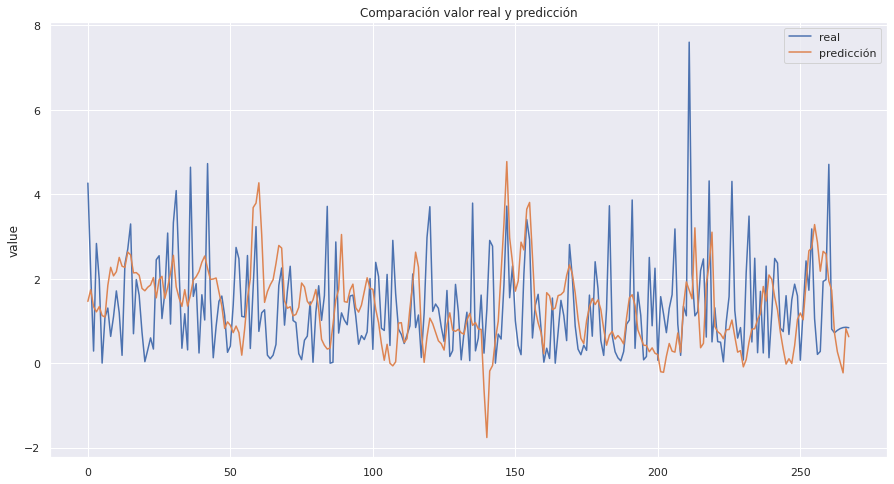

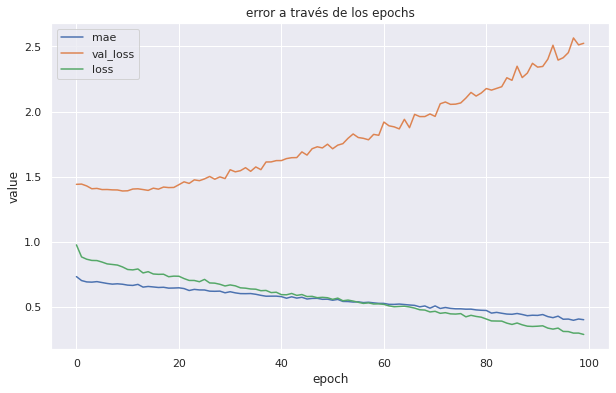

9/9 [==============================] - 0s 8ms/step
Evaluation metric results:
MSE is : 1.0999215732658625
MAE is : 0.6462754492280073
RMSE is : 1.0487714590252075
MAPE is : 32.6654015134604
Evaluation metric results:
MSE is : 1.93041320243309
MAE is : 1.0973828038697524
RMSE is : 1.3893931057958686
MAPE is : 56.15827012323369
(634, 8, 8) (634, 1)
(268, 8, 8) (268, 1)
Epoch 1/100
32/32 [==============================] - 6s 67ms/step - loss: 1.0364 - mae: 0.7498 - val_loss: 1.4574 - val_mae: 0.7795
Epoch 2/100
32/32 [==============================] - 1s 46ms/step - loss: 0.8936 - mae: 0.7088 - val_loss: 1.4655 - val_mae: 0.7564
Epoch 3/100
32/32 [==============================] - 1s 46ms/step - loss: 0.8700 - mae: 0.6915 - val_loss: 1.4467 - val_mae: 0.7570
Epoch 4/100
32/32 [==============================] - 1s 44ms/step - loss: 0.8582 - mae: 0.6898 - val_loss: 1.4109 - val_mae: 0.7453
Epoch 5/100
32/32 [==============================] - 2s 48ms/step - loss: 0.8561 - mae: 0.6932 - val_l

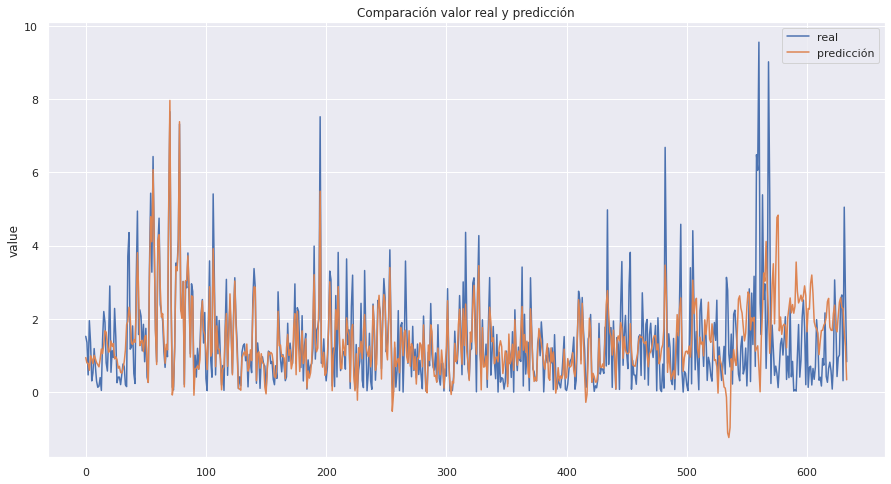

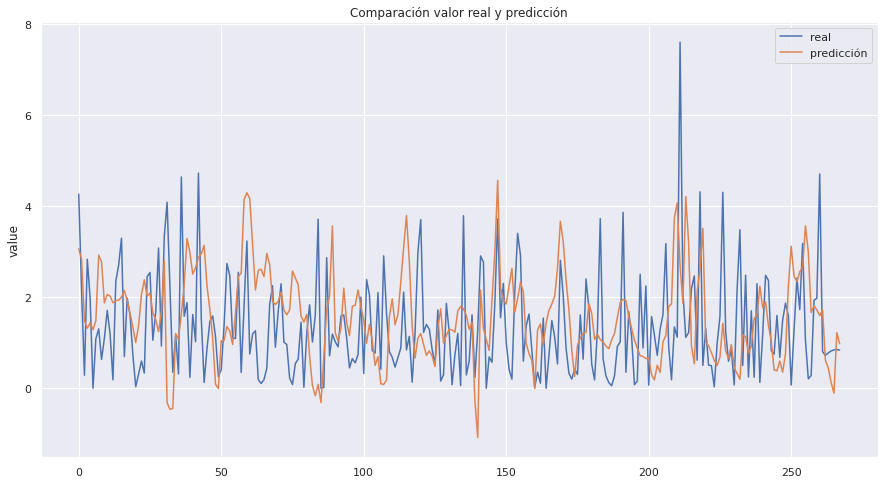

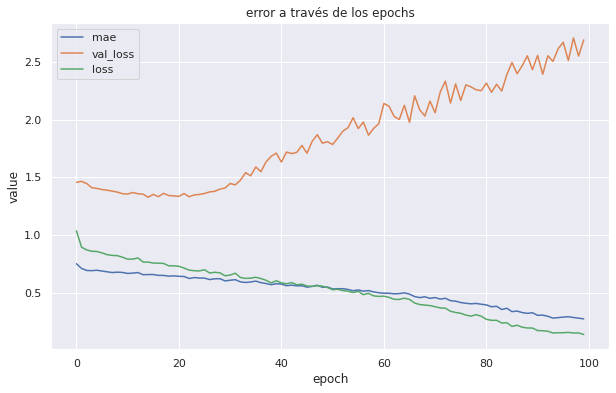

9/9 [==============================] - 0s 23ms/step
Evaluation metric results:
MSE is : 0.9972858124965505
MAE is : 0.5751687598843694
RMSE is : 0.9986419841447437
MAPE is : 28.936700451773888
Evaluation metric results:
MSE is : 1.9660500627636257
MAE is : 1.054350877480136
RMSE is : 1.40215907184728
MAPE is : 49.61264621927641
(632, 10, 8) (632, 1)
(266, 10, 8) (266, 1)
Epoch 1/100
32/32 [==============================] - 4s 32ms/step - loss: 1.0644 - mae: 0.7863 - val_loss: 1.6391 - val_mae: 0.7795
Epoch 2/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9901 - mae: 0.7489 - val_loss: 1.6055 - val_mae: 0.7806
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9563 - mae: 0.7311 - val_loss: 1.5870 - val_mae: 0.7767
Epoch 4/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9365 - mae: 0.7195 - val_loss: 1.5682 - val_mae: 0.7781
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9198 - mae: 0.7111 - v

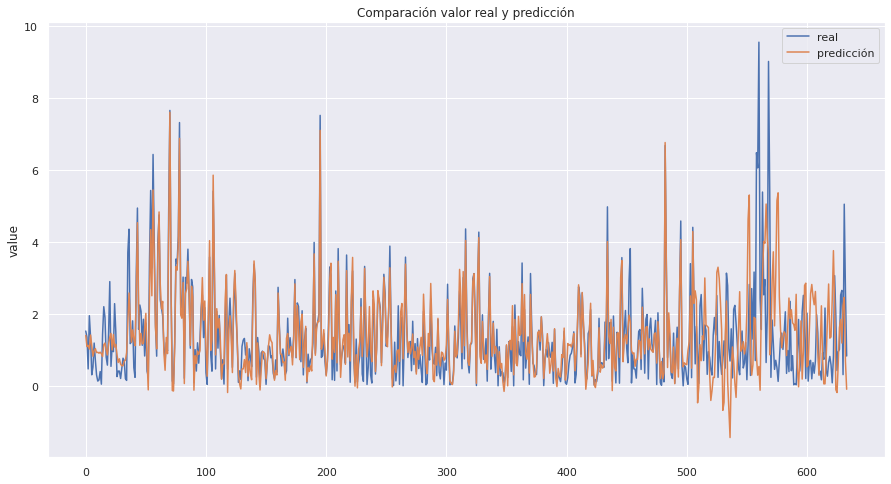

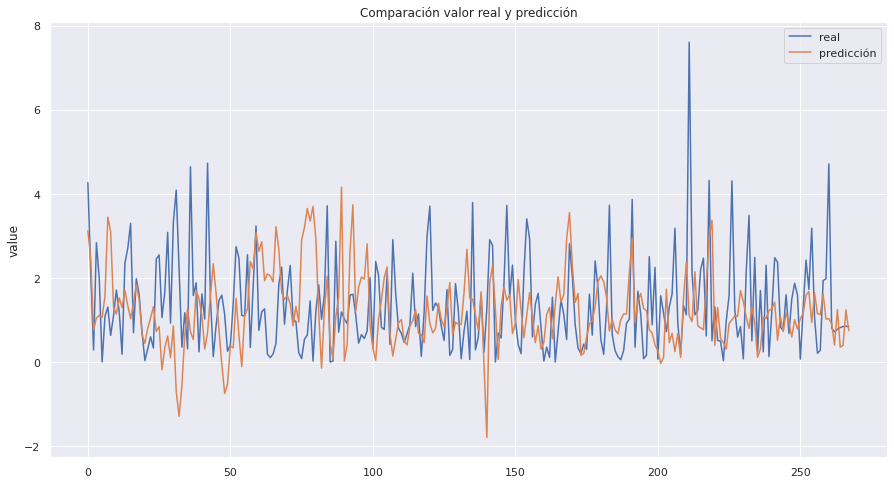

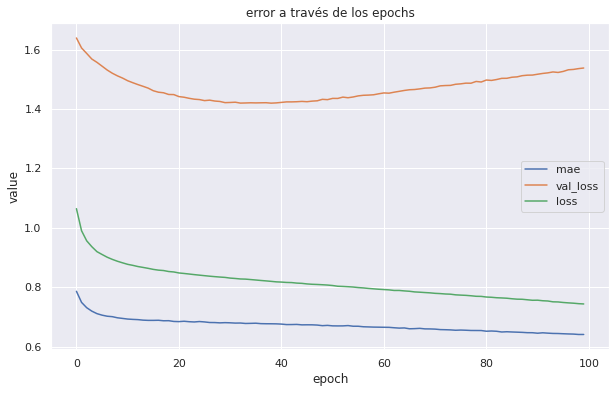

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.40341143263201
MAE is : 0.8390942069289773
RMSE is : 1.1846566728938852
MAPE is : 40.466623589478765
Evaluation metric results:
MSE is : 1.169662310151378
MAE is : 0.8481258534107052
RMSE is : 1.0815092741864851
MAPE is : 41.32654242488077
(632, 10, 8) (632, 1)
(266, 10, 8) (266, 1)
Epoch 1/100
32/32 [==============================] - 5s 38ms/step - loss: 0.9847 - mae: 0.7368 - val_loss: 1.4738 - val_mae: 0.7667
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9231 - mae: 0.7196 - val_loss: 1.4504 - val_mae: 0.7616
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.8988 - mae: 0.7101 - val_loss: 1.4409 - val_mae: 0.7548
Epoch 4/100
32/32 [==============================] - 0s 14ms/step - loss: 0.8856 - mae: 0.6992 - val_loss: 1.4285 - val_mae: 0.7572
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 0.8738 - mae: 0.6951 - va

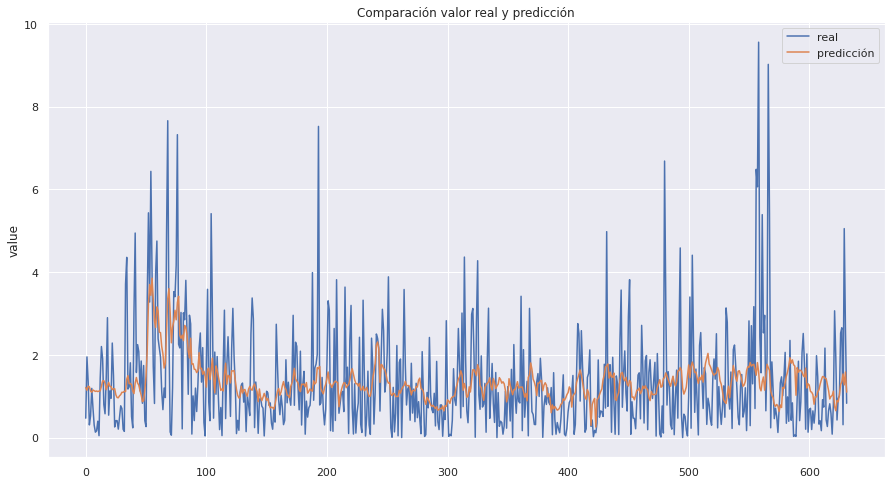

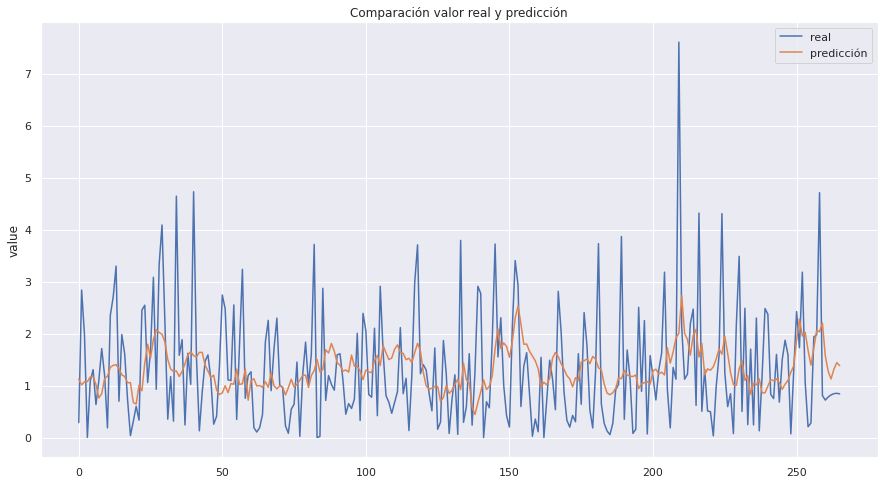

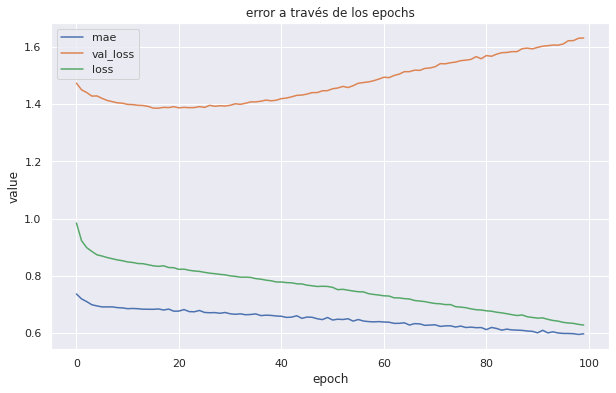

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.2802425304940324
MAE is : 0.797442156758664
RMSE is : 1.1314780291698254
MAPE is : 38.36752296977984
Evaluation metric results:
MSE is : 1.320670593212972
MAE is : 0.8462551287134332
RMSE is : 1.1492043304882609
MAPE is : 37.842709404881134
(632, 10, 8) (632, 1)
(266, 10, 8) (266, 1)
Epoch 1/100
32/32 [==============================] - 4s 38ms/step - loss: 0.9583 - mae: 0.7171 - val_loss: 1.5025 - val_mae: 0.7651
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: 0.9042 - mae: 0.7059 - val_loss: 1.4656 - val_mae: 0.7665
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.8938 - mae: 0.7012 - val_loss: 1.4521 - val_mae: 0.7600
Epoch 4/100
32/32 [==============================] - 0s 14ms/step - loss: 0.8925 - mae: 0.6961 - val_loss: 1.4374 - val_mae: 0.7625
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 0.8759 - mae: 0.6940 - v

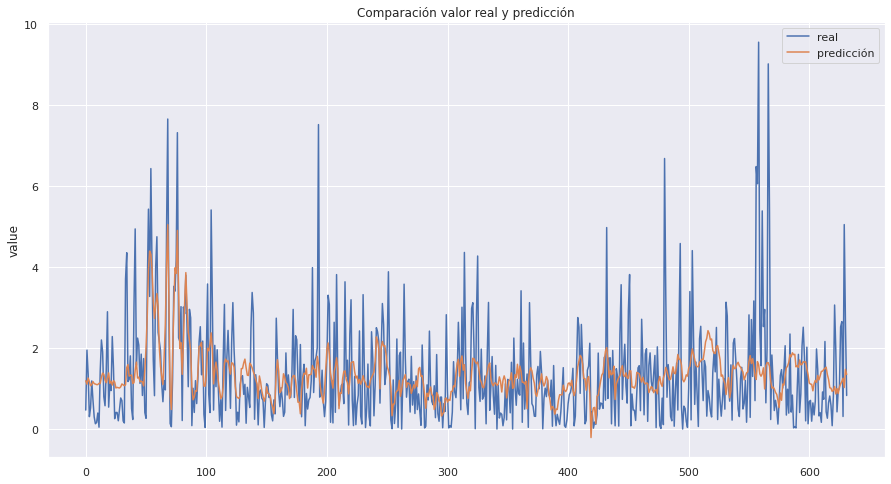

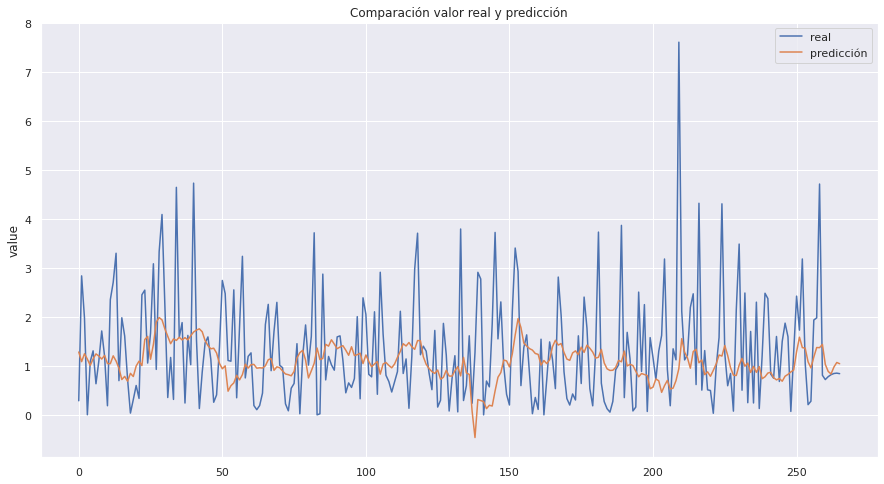

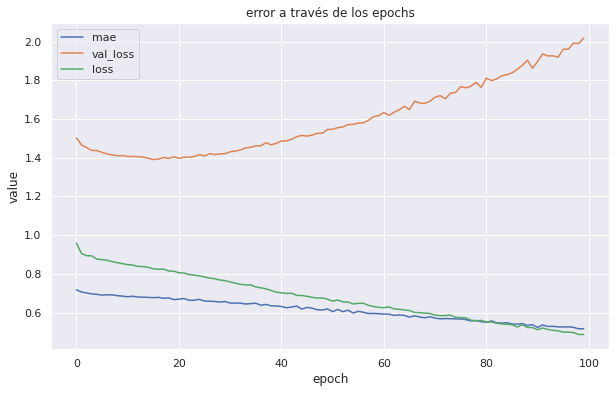

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.2174052243130202
MAE is : 0.7637877854629813
RMSE is : 1.1033608767366279
MAPE is : 38.33985291314115
Evaluation metric results:
MSE is : 2.4715361149973147
MAE is : 1.2007469815654124
RMSE is : 1.5721119918750428
MAPE is : 50.68507269047095
(632, 10, 8) (632, 1)
(266, 10, 8) (266, 1)
Epoch 1/100
32/32 [==============================] - 5s 41ms/step - loss: 0.9395 - mae: 0.7117 - val_loss: 1.5095 - val_mae: 0.7608
Epoch 2/100
32/32 [==============================] - 1s 18ms/step - loss: 0.8908 - mae: 0.7037 - val_loss: 1.4593 - val_mae: 0.7665
Epoch 3/100
32/32 [==============================] - 1s 16ms/step - loss: 0.8764 - mae: 0.6991 - val_loss: 1.4410 - val_mae: 0.7662
Epoch 4/100
32/32 [==============================] - 1s 18ms/step - loss: 0.8848 - mae: 0.6953 - val_loss: 1.4331 - val_mae: 0.7601
Epoch 5/100
32/32 [==============================] - 1s 18ms/step - loss: 0.8618 - mae: 0.6937 - 

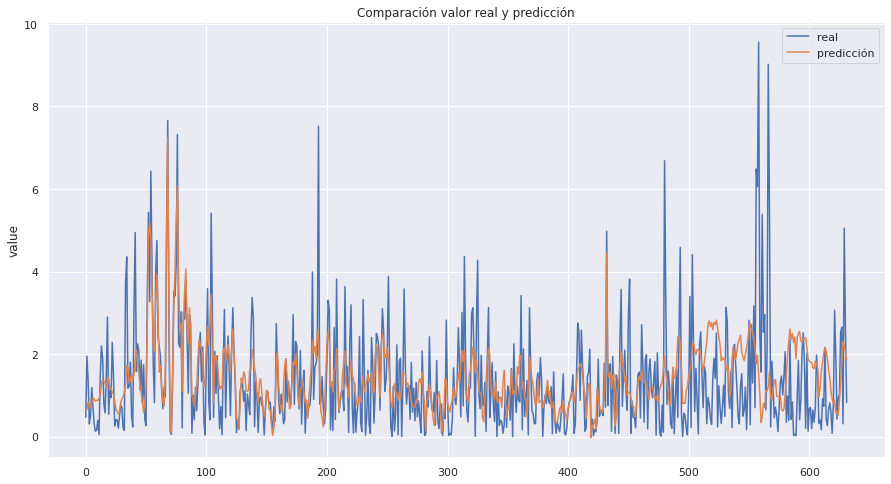

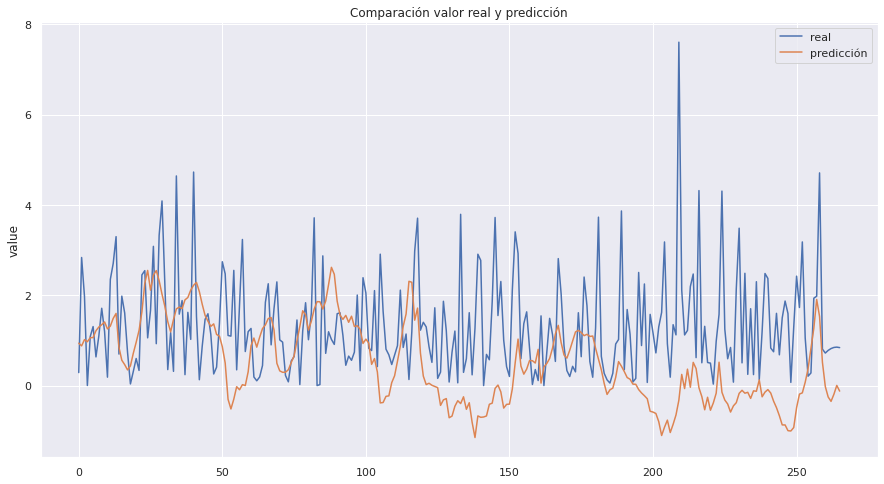

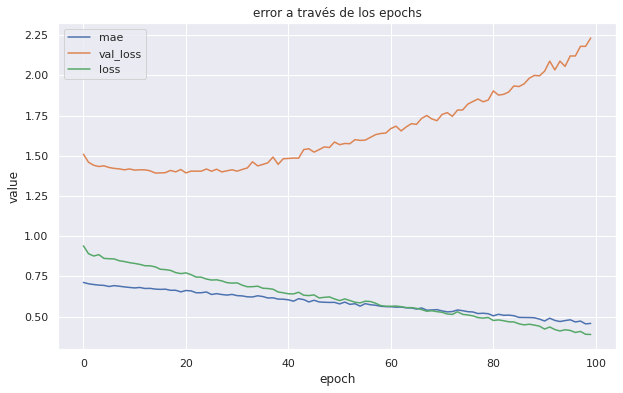

9/9 [==============================] - 0s 7ms/step
Evaluation metric results:
MSE is : 1.1573000788871322
MAE is : 0.7165976628748186
RMSE is : 1.075778824334785
MAPE is : 35.479511522473075
Evaluation metric results:
MSE is : 1.6851996057316883
MAE is : 0.9972196609257177
RMSE is : 1.2981523815529856
MAPE is : 48.54581025641735
(632, 10, 8) (632, 1)
(266, 10, 8) (266, 1)
Epoch 1/100
32/32 [==============================] - 5s 58ms/step - loss: 0.9490 - mae: 0.7215 - val_loss: 1.4978 - val_mae: 0.7597
Epoch 2/100
32/32 [==============================] - 1s 29ms/step - loss: 0.8971 - mae: 0.7091 - val_loss: 1.4641 - val_mae: 0.7554
Epoch 3/100
32/32 [==============================] - 1s 34ms/step - loss: 0.8734 - mae: 0.7000 - val_loss: 1.4377 - val_mae: 0.7659
Epoch 4/100
32/32 [==============================] - 1s 33ms/step - loss: 0.8958 - mae: 0.7030 - val_loss: 1.4379 - val_mae: 0.7553
Epoch 5/100
32/32 [==============================] - 1s 33ms/step - loss: 0.8612 - mae: 0.6979 - 

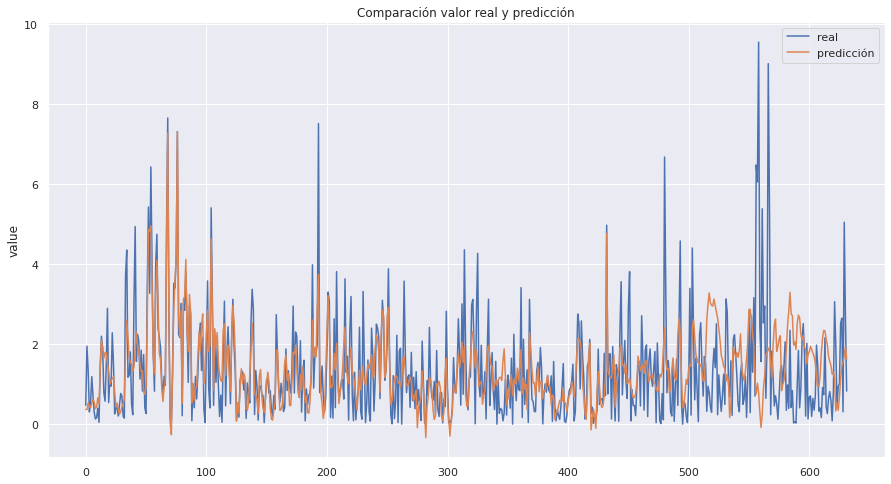

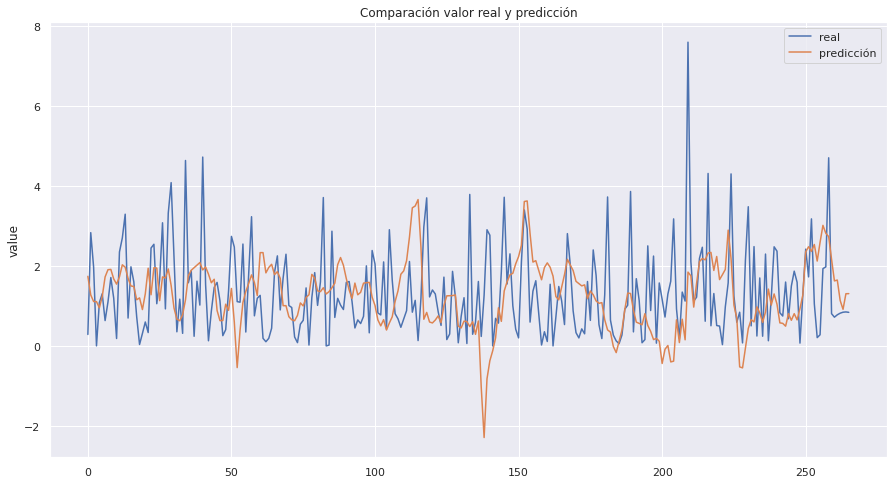

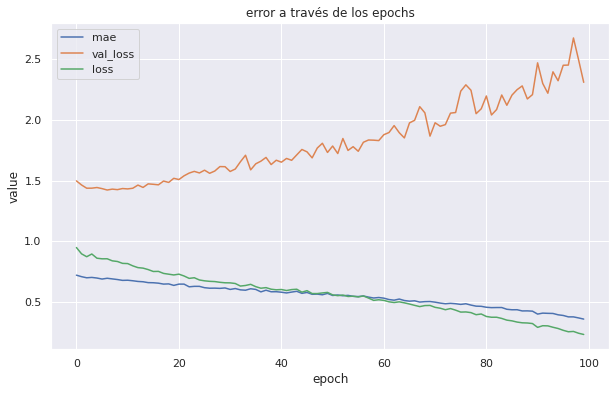

9/9 [==============================] - 0s 11ms/step
Evaluation metric results:
MSE is : 1.0482013891715407
MAE is : 0.6475435066580354
RMSE is : 1.0238170682165544
MAPE is : 31.281286927911626
Evaluation metric results:
MSE is : 2.6291856025403346
MAE is : 1.2856967366050147
RMSE is : 1.6214763650884136
MAPE is : 69.53119394022626
(632, 10, 8) (632, 1)
(266, 10, 8) (266, 1)
Epoch 1/100
32/32 [==============================] - 8s 117ms/step - loss: 0.9664 - mae: 0.7327 - val_loss: 1.4906 - val_mae: 0.7548
Epoch 2/100
32/32 [==============================] - 3s 82ms/step - loss: 0.8882 - mae: 0.7078 - val_loss: 1.4552 - val_mae: 0.7457
Epoch 3/100
32/32 [==============================] - 3s 86ms/step - loss: 0.8607 - mae: 0.6974 - val_loss: 1.4194 - val_mae: 0.7543
Epoch 4/100
32/32 [==============================] - 3s 82ms/step - loss: 0.8826 - mae: 0.7017 - val_loss: 1.4229 - val_mae: 0.7446
Epoch 5/100
32/32 [==============================] - 3s 87ms/step - loss: 0.8466 - mae: 0.6959

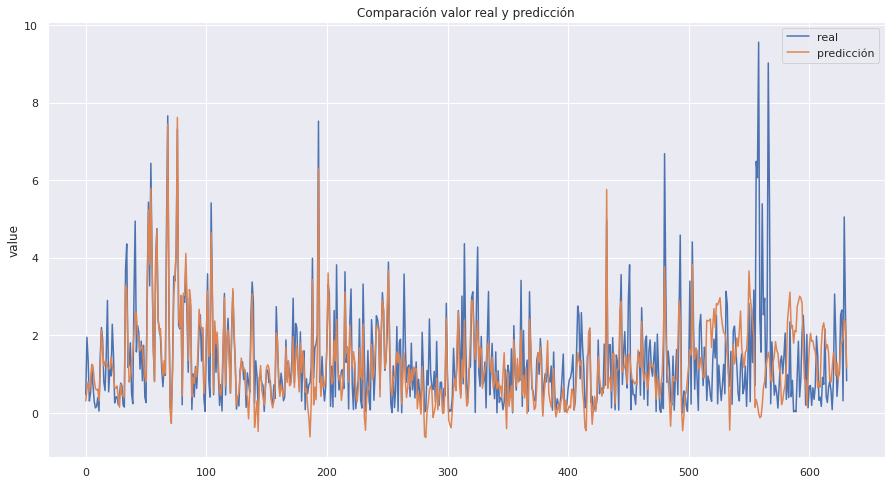

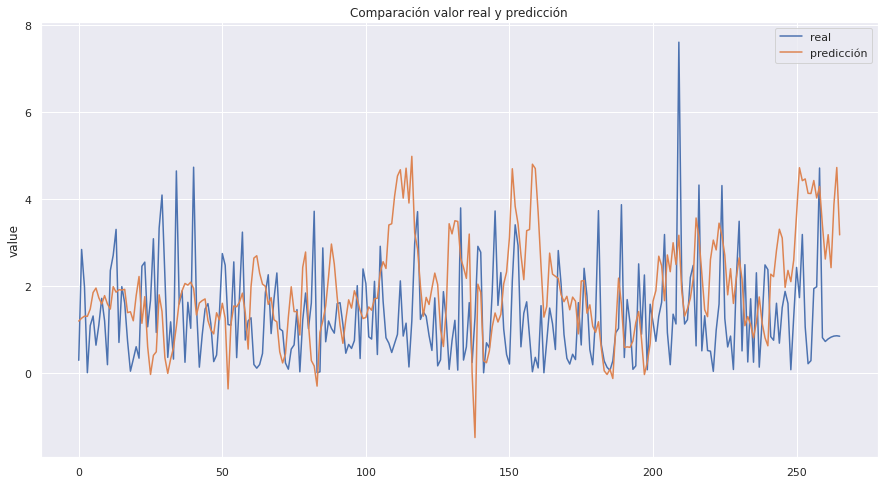

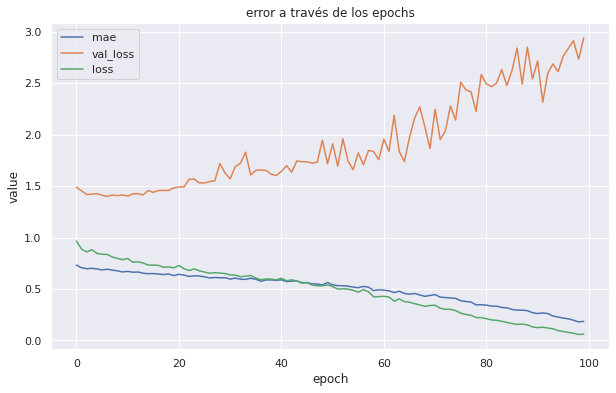

9/9 [==============================] - 0s 25ms/step
Evaluation metric results:
MSE is : 0.9776239402792406
MAE is : 0.46707650637930215
RMSE is : 0.9887486739709139
MAPE is : 22.61837069915425
Evaluation metric results:
MSE is : 2.463672476455634
MAE is : 1.229322197586446
RMSE is : 1.569609020251742
MAPE is : 65.68140964448834
(627, 15, 8) (627, 1)
(261, 15, 8) (261, 1)
Epoch 1/100
32/32 [==============================] - 5s 53ms/step - loss: 0.9803 - mae: 0.7359 - val_loss: 1.7250 - val_mae: 0.7933
Epoch 2/100
32/32 [==============================] - 1s 18ms/step - loss: 0.9432 - mae: 0.7172 - val_loss: 1.6800 - val_mae: 0.7903
Epoch 3/100
32/32 [==============================] - 1s 19ms/step - loss: 0.9301 - mae: 0.7141 - val_loss: 1.6456 - val_mae: 0.7871
Epoch 4/100
32/32 [==============================] - 1s 20ms/step - loss: 0.9217 - mae: 0.7111 - val_loss: 1.6286 - val_mae: 0.7851
Epoch 5/100
32/32 [==============================] - 1s 19ms/step - loss: 0.9149 - mae: 0.7075 - v

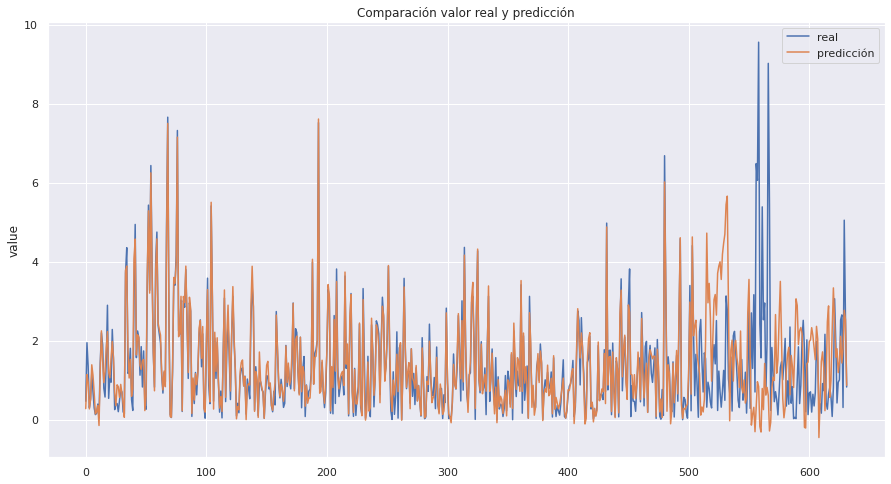

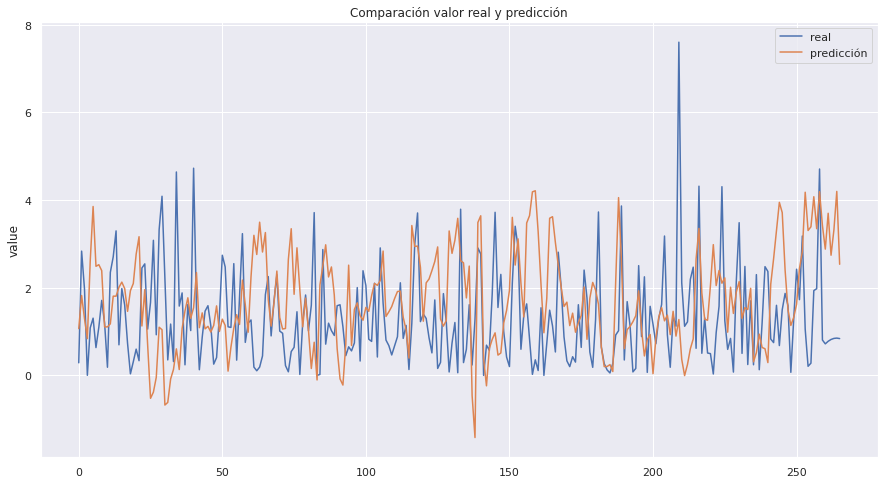

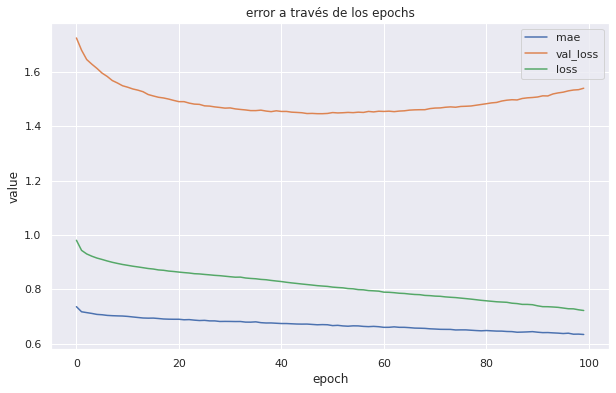

9/9 [==============================] - 0s 5ms/step
Evaluation metric results:
MSE is : 1.3772473720776073
MAE is : 0.8314940060022409
RMSE is : 1.1735618313823977
MAPE is : 39.62524533992633
Evaluation metric results:
MSE is : 1.453347570943888
MAE is : 0.9691019732299161
RMSE is : 1.20554865971635
MAPE is : 53.25671025643537
(627, 15, 8) (627, 1)
(261, 15, 8) (261, 1)
Epoch 1/100
32/32 [==============================] - 7s 84ms/step - loss: 1.0076 - mae: 0.7623 - val_loss: 1.5974 - val_mae: 0.7745
Epoch 2/100
32/32 [==============================] - 1s 23ms/step - loss: 0.9358 - mae: 0.7165 - val_loss: 1.5760 - val_mae: 0.7745
Epoch 3/100
32/32 [==============================] - 1s 23ms/step - loss: 0.9146 - mae: 0.7085 - val_loss: 1.5569 - val_mae: 0.7724
Epoch 4/100
32/32 [==============================] - 1s 26ms/step - loss: 0.9029 - mae: 0.7025 - val_loss: 1.5468 - val_mae: 0.7700
Epoch 5/100
32/32 [==============================] - 1s 19ms/step - loss: 0.8921 - mae: 0.6970 - val

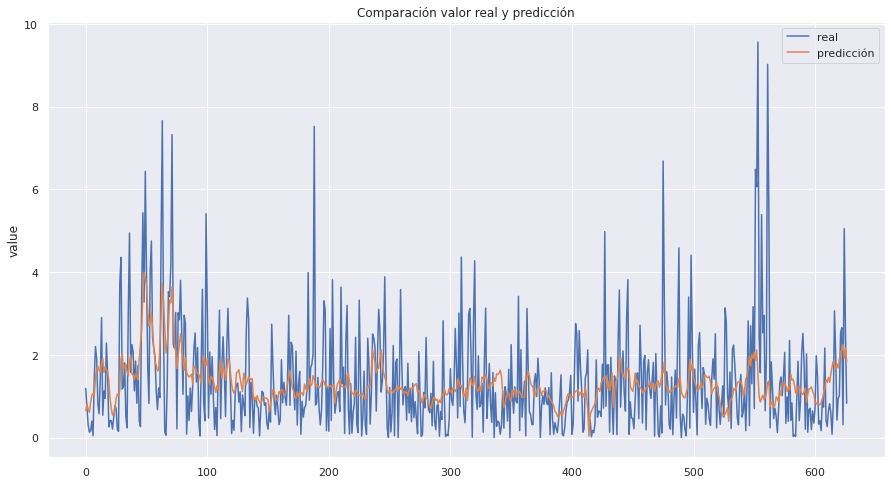

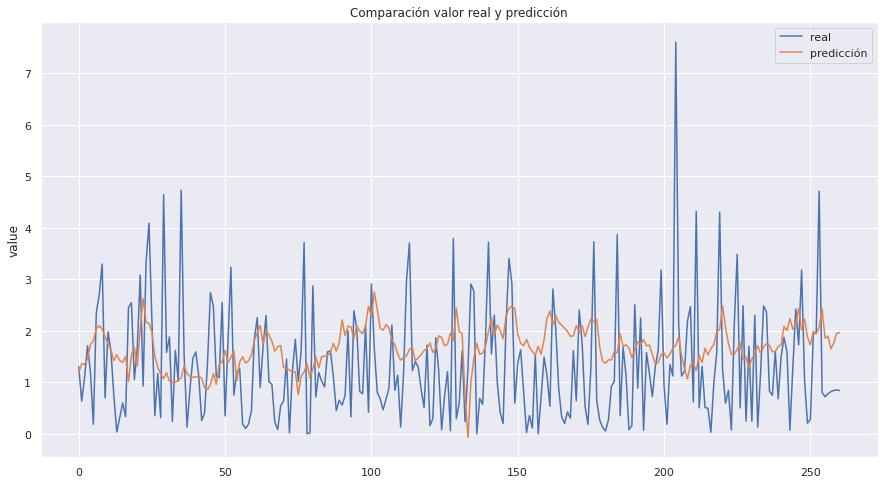

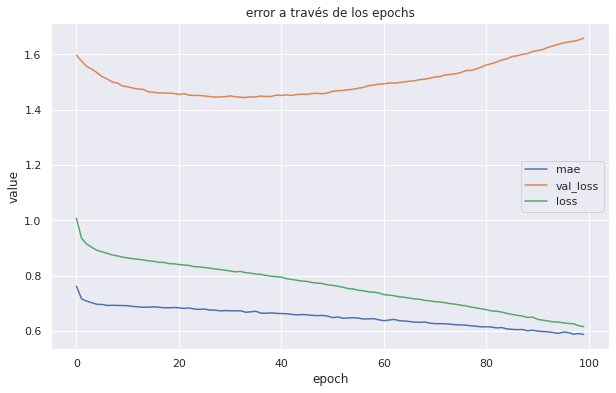

9/9 [==============================] - 0s 6ms/step
Evaluation metric results:
MSE is : 1.2755904640838989
MAE is : 0.8016745971208775
RMSE is : 1.1294204106903234
MAPE is : 39.5397428485539
Evaluation metric results:
MSE is : 1.3359249603275354
MAE is : 0.8882236027974812
RMSE is : 1.15582220100132
MAPE is : 45.91309391854189
(627, 15, 8) (627, 1)
(261, 15, 8) (261, 1)
Epoch 1/100
32/32 [==============================] - 7s 59ms/step - loss: 0.9376 - mae: 0.7290 - val_loss: 1.4958 - val_mae: 0.7806
Epoch 2/100
32/32 [==============================] - 1s 27ms/step - loss: 0.9016 - mae: 0.6968 - val_loss: 1.4810 - val_mae: 0.7654
Epoch 3/100
32/32 [==============================] - 1s 23ms/step - loss: 0.8915 - mae: 0.7024 - val_loss: 1.4640 - val_mae: 0.7649
Epoch 4/100
32/32 [==============================] - 1s 21ms/step - loss: 0.8862 - mae: 0.6976 - val_loss: 1.4641 - val_mae: 0.7638
Epoch 5/100
32/32 [==============================] - 1s 23ms/step - loss: 0.8787 - mae: 0.6929 - val

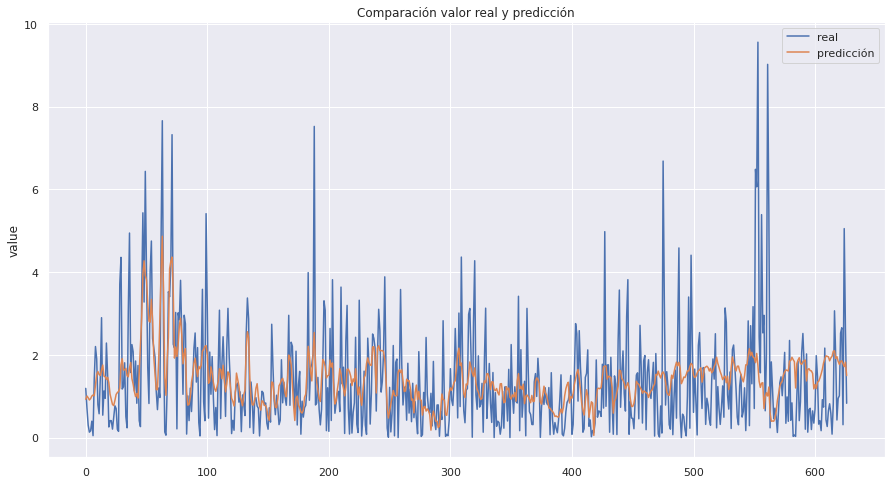

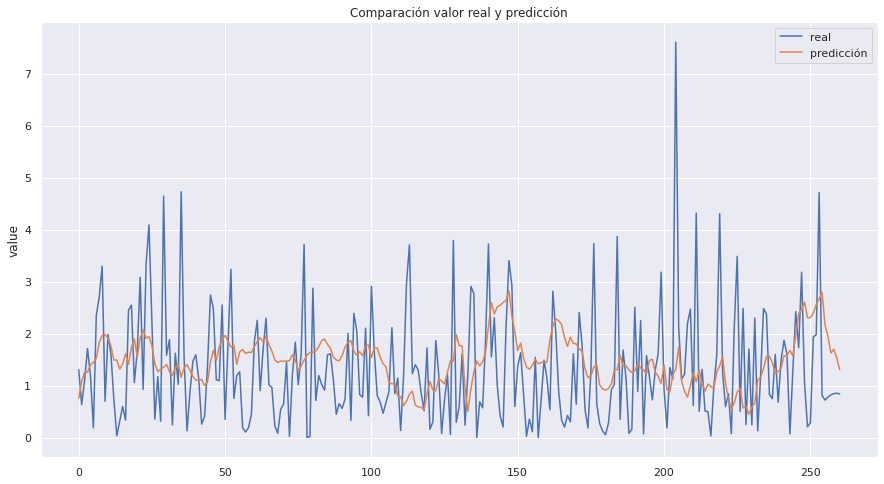

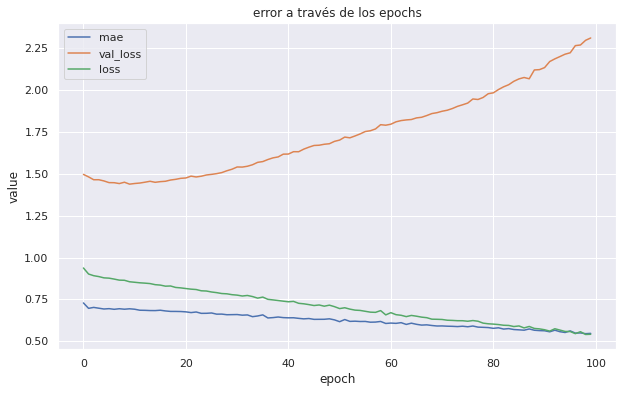

9/9 [==============================] - 0s 7ms/step
Evaluation metric results:
MSE is : 1.3739774811691392
MAE is : 0.7957149150650299
RMSE is : 1.1721678553727444
MAPE is : 38.84942990590091
Evaluation metric results:
MSE is : 1.6179758012539065
MAE is : 0.9865690327911049
RMSE is : 1.271996777218365
MAPE is : 50.564246883865124
(627, 15, 8) (627, 1)
(261, 15, 8) (261, 1)
Epoch 1/100
32/32 [==============================] - 10s 118ms/step - loss: 0.9401 - mae: 0.7231 - val_loss: 1.4730 - val_mae: 0.7963
Epoch 2/100
32/32 [==============================] - 1s 32ms/step - loss: 0.9057 - mae: 0.6995 - val_loss: 1.4610 - val_mae: 0.7638
Epoch 3/100
32/32 [==============================] - 1s 33ms/step - loss: 0.8826 - mae: 0.7028 - val_loss: 1.4340 - val_mae: 0.7687
Epoch 4/100
32/32 [==============================] - 1s 32ms/step - loss: 0.8786 - mae: 0.6961 - val_loss: 1.4303 - val_mae: 0.7681
Epoch 5/100
32/32 [==============================] - 1s 38ms/step - loss: 0.8670 - mae: 0.6905 

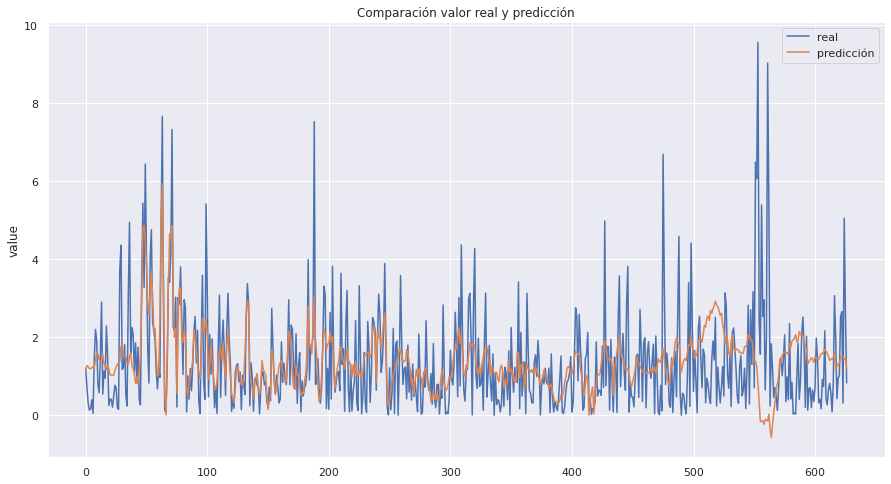

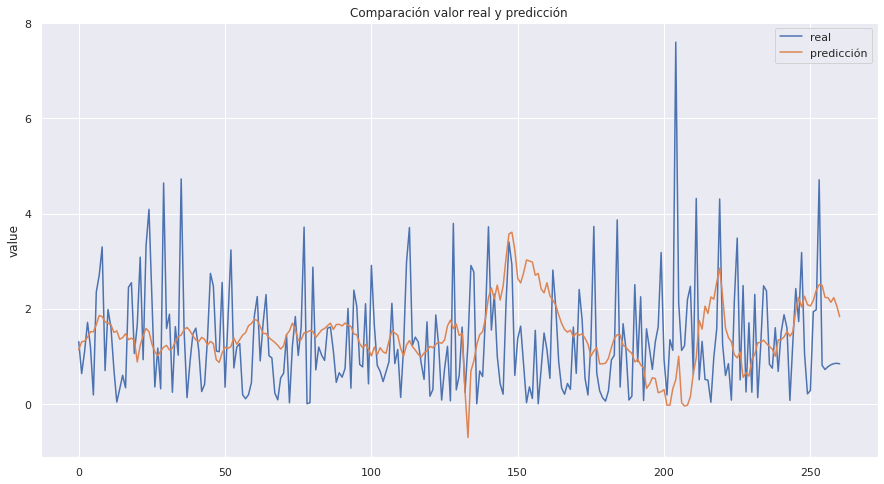

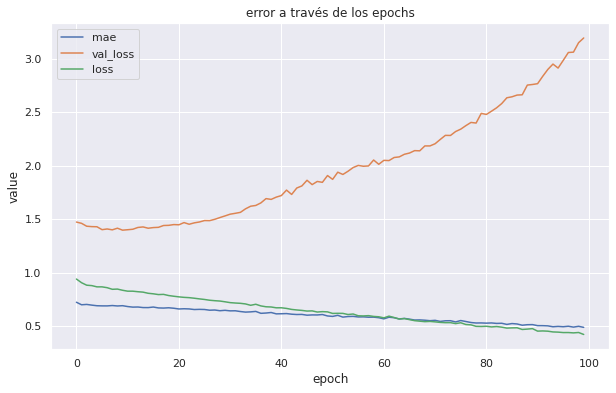

9/9 [==============================] - 0s 17ms/step
Evaluation metric results:
MSE is : 1.4984836502971177
MAE is : 0.7913359933906584
RMSE is : 1.2241256676898487
MAPE is : 39.72800264445049
Evaluation metric results:
MSE is : 3.0464033515389626
MAE is : 1.3353728693413416
RMSE is : 1.7453948984510532
MAPE is : 67.05775848277342
(627, 15, 8) (627, 1)
(261, 15, 8) (261, 1)
Epoch 1/100
32/32 [==============================] - 12s 132ms/step - loss: 0.9477 - mae: 0.7306 - val_loss: 1.4727 - val_mae: 0.7799
Epoch 2/100
32/32 [==============================] - 2s 72ms/step - loss: 0.9054 - mae: 0.7030 - val_loss: 1.4531 - val_mae: 0.7514
Epoch 3/100
32/32 [==============================] - 2s 63ms/step - loss: 0.8758 - mae: 0.7002 - val_loss: 1.4293 - val_mae: 0.7447
Epoch 4/100
32/32 [==============================] - 2s 68ms/step - loss: 0.8733 - mae: 0.6960 - val_loss: 1.4335 - val_mae: 0.7514
Epoch 5/100
32/32 [==============================] - 2s 64ms/step - loss: 0.8604 - mae: 0.6920

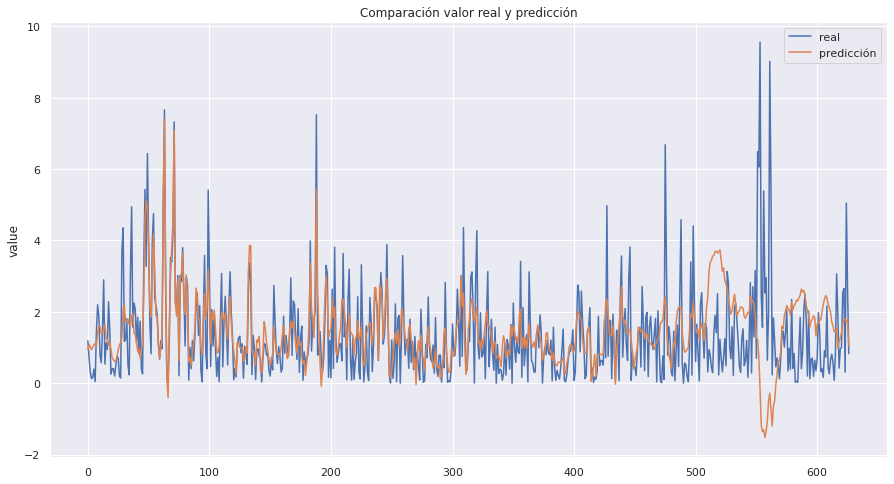

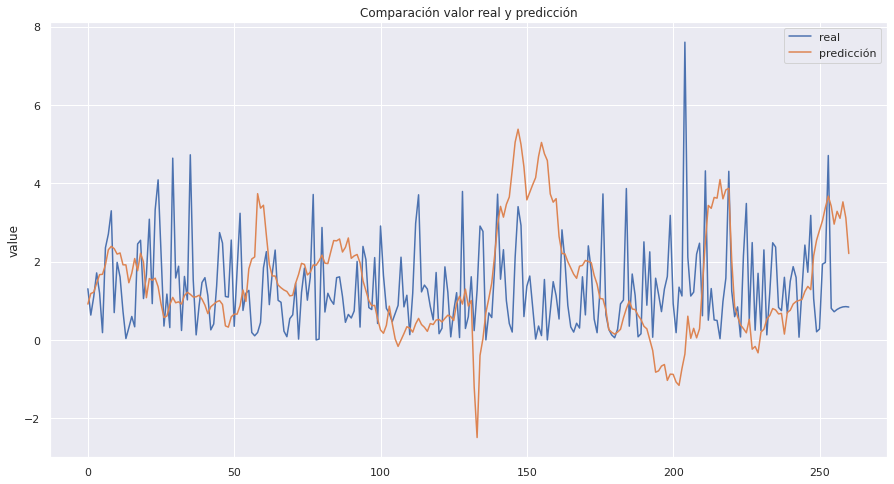

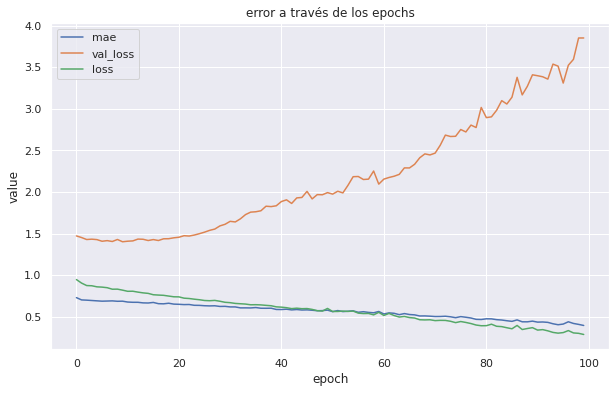

9/9 [==============================] - 0s 19ms/step
Evaluation metric results:
MSE is : 1.5275004949506978
MAE is : 0.7209921590268734
RMSE is : 1.2359209096664308
MAPE is : 36.389189148435015
Evaluation metric results:
MSE is : 3.044508171258497
MAE is : 1.414584109703175
RMSE is : 1.7448519052511298
MAPE is : 73.18394181461703
(627, 15, 8) (627, 1)
(261, 15, 8) (261, 1)
Epoch 1/100
32/32 [==============================] - 14s 237ms/step - loss: 0.9754 - mae: 0.7418 - val_loss: 1.4818 - val_mae: 0.7870
Epoch 2/100
32/32 [==============================] - 5s 147ms/step - loss: 0.9047 - mae: 0.7039 - val_loss: 1.4477 - val_mae: 0.7481
Epoch 3/100
32/32 [==============================] - 4s 141ms/step - loss: 0.8714 - mae: 0.6994 - val_loss: 1.4204 - val_mae: 0.7422
Epoch 4/100
32/32 [==============================] - 4s 134ms/step - loss: 0.8706 - mae: 0.6967 - val_loss: 1.4297 - val_mae: 0.7494
Epoch 5/100
32/32 [==============================] - 4s 118ms/step - loss: 0.8559 - mae: 0.6

In [ ]:
lags=[5,8,10,15]
neuronss=[16,32,64,128,256,512]
results_models={i:{} for i in lags}
for lg in lags:
    for neuron in neuronss:
        results_models[lg][neuron]=Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons=neuron,attributes=8,epochss=100,batch_sizze=16,lag=lg)